In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

In [2]:
df = pd.read_csv("../../data/v0_2.csv.gz", 
                 dtype=dict(Provenance="string", RelatedWorks="string"))

# TODO: save & load DF s.t. these lines are not necessary here                
df["ObjectID"] = df.ObjectID.astype("int")
df = df.set_index("ObjectID")

In [ ]:
df2 = df[(df.BeginISODate+df.EndISODate) > 0]

df2.apply(lambda r: len(str(r.Title) + str(r.Description)) > 6, axis="columns").sum()/df2.shape[0]

In [ ]:
type(df2.iloc[0].Description)

In [ ]:

import spacy
from nltk import Tree

nlp = spacy.load("nl_core_news_sm")

def to_nltk_tree(node):
    if node.n_lefts + node.n_rights > 0:
        return Tree(node.orth_, [to_nltk_tree(child) for child in node.children])
    else:
        return node.orth_
    
doc = nlp(df.Description.dropna().iloc[0])
print(doc)
[to_nltk_tree(sent.root).pretty_print() for sent in doc.sents]

In [ ]:
from spacy import displacy
displacy.render(doc, style='dep')

In [ ]:
[nlp(t) for t in tqdm(df.Description) if isinstance(t, str)]

---
# Search

In [ ]:
kws = "" # "hello, goodbye"
prep_kws = "|".join(kws.lower().replace(", ", ",").split(","))
        
if (not kws.strip()) or (not prep_kws):
    does_contain = [True]*df.shape[0]
else:
    print("what")
    
print(does_contain)

In [ ]:
from urllib.parse import unquote

unquote('"objectKeywords"%3A""%2C"objectStartDate"%3A""%2C"objectEndDate"')

---
# Dates

 1. make all dates at least 1 (because python cannot deal with years <= 0)  
    (or drop non-positive dates)  
    (drop objects with EndISODate <= 0 in any case (doesn't make any sense))  
 
 2. convert all year values to %Y-%m-%d format (expected by Werner's API)  
    (by using datetime.strptime; allows comparison with > )  

In [ ]:
from datetime import datetime
frmt = "%Y-%m-%d"
start_year, end_year = datetime.strptime("2011-02-01", frmt), datetime.strptime("2013-10-02", frmt)

In [ ]:
(start_year.year > df.BeginISODate).sum()

In [ ]:
df.BeginISODate[(df.BeginISODate > 1500)].hist(bins=100)

### 1.

In [ ]:
df = df[df.EndISODate > 0]

# drop
df = df[df.BeginISODate > 0]

# change
df["BeginISODate"] = df.BeginISODate.replace(0, 1)

### 2.

In [ ]:
df["start_date"] = df.BeginISODate.astype(str).str.zfill(4).apply(lambda s: dt.strptime(s, "%Y"))
df["end_date"] = df.EndISODate.astype(str).str.zfill(4).apply(lambda s: dt.strptime(s, "%Y"))

---
# Keyword Search Dev

In [ ]:
kws = "Maarten Sint"
prep_kws = "|".join(kws.lower().replace(", ", ",").split(","))

In [ ]:
prep_kws

In [ ]:
d = dict(a=)

d.get("a", False)

In [ ]:
def f(**kwargs):
    print(kwargs)
    
    
d = dict(a=13)
f(a=0, **d)

---
# Integrating TypicalityEngine

In [ ]:
from src.datasets import NMvW
from src.engines.TypicalityEnginev0 import Typicality, TypicalityEngine

NMvW.data = NMvW.data.iloc[:10000]

In [ ]:
typE = TypicalityEngine(id_="TypicalityEnginev0",
                           name="TypicalityEngine/v0",
                           dataset=NMvW,
                           params=[],
                       from_saved=False)

In [ ]:
texts = NMvW.data.sample(frac=0.3).fillna("")

typs, details = typE.score_and_detail(texts)

In [ ]:
import seaborn as sns
sns.histplot(typs, color="blue")

In [ ]:
details.iloc[-1]

In [ ]:
import joblib
joblib.dump(typE.typicality, "test.pkl")

In [ ]:
import joblib
joblib.dump(typE, "test.pkl")

---

In [ ]:
import joblib
typ2 = joblib.load("test.pkl")

In [ ]:
texts = NMvW.data.sample(frac=0.3).fillna("")
typs2, details2 = typ2.score_and_detail(texts)

In [ ]:
typs, details = typE.score_and_detail(texts)

In [ ]:
(typs == typs2)

# Fast Iteration over Results

In [ ]:
df = pd.read_csv("../../data/v0_2.csv.gz", 
                 dtype=dict(Provenance="string", RelatedWorks="string"))

# TODO: save & load DF s.t. these lines are not necessary here                
df["ObjectID"] = df.ObjectID.astype("int")
df = df.set_index("ObjectID")

In [ ]:
ids = df.index.astype("string")
titles = df.Title.fillna("").astype("string")
thumbnails = pd.Series([""]*df.shape[0], 
                       name="Thumbnail",
                      index=df.index).astype("string")

In [ ]:
r = pd.concat([titles, thumbnails], axis=1)
r.index, ids

In [ ]:
r#.astype("string")

In [ ]:
lens = []
for i, row in tqdm(r.to_dict("index").items()):
    lens.append(sum(map(len, row.values())))

In [ ]:
lens = []
for i in tqdm(range(r.shape[0])):
    lens.append(sum(map(len, r.iloc[i])))

In [ ]:
r_ = r.apply(lambda col: col.str.replace(" ", "X"), axis=0)
r_.columns = [c + "X" for c in r_.columns]
r2 = pd.concat([r, r_], axis=1)

In [ ]:
t = pd.Series(np.random.random(size=df.shape[0]), index=df.index)

In [ ]:
t.iloc[0].round(3)

---
# TypicalityEngine Value Range

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
scores = pd.read_csv("/home/valentin/Desktop/scores.csv").set_index("ObjectID")["score"]
score_details = pd.read_csv("/home/valentin/Desktop/score_details.csv").set_index("ObjectID")
score_details = score_details["score_details"]

In [ ]:
_=plt.hist(scores, bins=100)
# _=plt.hist((1/scores)-1, bins=100)

In [ ]:
(scores < 100).sum()/scores.shape[0]

_= plt.hist(scores[(scores > 0) & (scores < 1)], bins=100)
# plt.xlim((0.95, 0.98))

In [ ]:
df.loc[.index]

In [ ]:
(df.fillna("").loc[scores[scores.between(0.96, 0.97)].index].Title.str.len() > 10)

In [ ]:
unnormed = (1/scores)-1

sns.histplot(unnormed.abs())

In [ ]:
plt.plot(1/(np.linspace(0., 10000., 1000)+1)**2)
plt.plot(1/(np.linspace(0., 10000., 1000)+1)**0.5)

plt.plot(1/np.log(np.linspace(0., 10000., 1000)+1))
# plt.plot(np.linspace(0., 1000., 1000)/(np.linspace(0., 1000., 1000).sum()))

# plt.ylim((0, 1))

In [ ]:
plt.hist(1/(unnormed.abs()+1))

In [ ]:
z = (unnormed - unnormed.mean())/(unnormed.var()**0.5)

sns.histplot(z)

In [ ]:
# unnormed = scores

def norm(v):
    return (v - v.min())/(v.max() - v.min())

normed = np.log(norm(norm(unnormed))+1)

sns.histplot(normed)

## Value Range of Score Details

In [ ]:
score_details = score_details.progress_apply(eval)

In [ ]:
score_details.iloc[10]

In [ ]:
(v-v.min())/(v.max() - v.min())

In [ ]:
d = {k: v for smalld in score_details for k, v in smalld.items()}

In [ ]:
def percentile_norm(v, q=99.5):
        return (v - np.percentile(v, 100-q))/(np.percentile(v, q) - np.percentile(v, 100-q))

vals = np.asarray([d[k] for k in sorted(d)])
abs_vals = abs(vals)
norm_vals = percentile_norm(abs(vals), q=99.)

In [ ]:
d_new = dict(zip(sorted(d), 1-norm_vals))

sorted(d_new.items(), key=lambda tup: tup[1])[-50:]

In [ ]:
_=plt.hist(vals, bins=100, histtype="step", lw=2)
_=plt.hist(abs_vals, bins=100, color="r", histtype="step", lw=2)
_=plt.hist(norm_vals, bins=100, color="green", histtype="step", lw=2)
_=plt.hist(1-norm_vals, bins=100, color="grey", histtype="step", lw=2)

# plt.xscale("log")
plt.yscale("log")
plt.xlim((-5, 5))

# for q in np.linspace(0, 100, 10):
#     plt.axvline(x=np.percentile(vals, q), label=str(q), c="r")
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
pd.Series(1-norm_vals).describe()

In [ ]:
sorted(d.items(), key=lambda tup: tup[1])[:50]

In [ ]:
a = np.asarray([v for d in tqdm(score_details) for v in d.values()])

In [ ]:
_=plt.hist(a, bins=50)

In [ ]:
def percentile_norm(v, q=99.5):
        return (v - np.percentile(v, 100-q))/(np.percentile(v, q) - np.percentile(v, 100-q))
    
_=plt.hist(percentile_norm(a), bins=50)

# Search Parameters

In [ ]:
df.AATCN.str.replace(" (doc.)", "", regex=False).value_counts()

---
# ContentLengthEngine Dev

In [ ]:
lengths = df.fillna("").progress_apply(lambda r: len(r.Title) + len(r.Description), axis="columns")

In [ ]:
_=plt.hist(lengths/1000, bins=5000)
plt.xlim((-0.4, 1.))

In [ ]:
_= plt.hist((lengths[lengths.between(0, 1000)]+1), bins=100)

In [ ]:
for m in np.linspace(100, 20000, 200):
    plt.plot([m], [lengths[lengths.between(0, m)].shape[0]/lengths.shape[0]], ".")
    
plt.xlim((0, 1000))
plt.ylim((0.8, 1.0))

In [ ]:
from src.engines.ContentLengthEnginev0 import ContentLengthEngine

cl_eng = ContentLengthEngine(id_="ContentLengthEnginev0",
                            name="ContentLengthEngine/v0",
                            dataset=df,
                            params=[])

In [ ]:
scores, details = cl_eng.score_and_detail(df)
scores = scores/cl_eng.max_len

In [ ]:
scores.hist(bins=2000)
plt.xlim((-0.1, 1.))

In [ ]:
scores

In [ ]:
df.progress_apply(lambda r: len(r), axis="columns", desc="somthing")

---

In [9]:
import numpy as np
sorted(((i, np.sin(i**0.5)) for i in range(10)), key=lambda t:t[1])[-2:]

[(3, 0.9870266449903538), (2, 0.9877659459927356)]

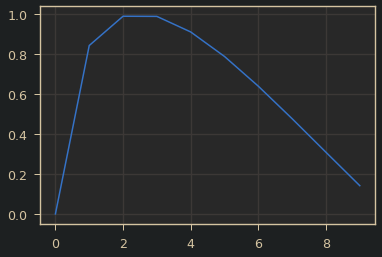

In [6]:
import matplotlib.pyplot as plt

plt.plot([np.sin(i**0.5) for i in range(10)])

---
# Dealing with Images

In [3]:
imgs = pd.read_excel("/home/valentin/Desktop/Primaire afbeeldingen.xlsx")

In [8]:
# len(set(df.index) & set(imgs.ObjectID))

imgs = imgs.set_index("ObjectID")

In [16]:
imgs.loc[df.index]

KeyError: '[2, 5, 8, 10, 14, 15, 16, 29, 41, 65, 66, 67, 73, 74, 79, 130, 136, 147, 152, 155, 161, 189, 193, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 210, 215, 233, 256, 258, 264, 326, 327, 328, 337, 338, 339, 342, 344, 351, 362, 1139, 1143, 1145, 1147, 1149, 1151, 1153, 1157, 1159, 1161, 1163, 1165, 1167, 1169, 1171, 1173, 1175, 1177, 1179, 1181, 1183, 2625, 588326, 588333, 585250, 585253, 585252, 585592, 585615, 585623, 585649, 585656, 585689, 585783, 585784, 585785, 585764, 585773, 585787, 585789, 585805, 586072, 586653, 586654, 586655, 586669, 586670, 586672, 586680, 586684, 586701, 586705, 586707, 586722, 586814, 586828, 586830, 586835, 586844, 588074, 588240, 588275, 588312, 589207, 589312, 589316, 589947, 589732, 589527, 589609, 589613, 589676, 589717, 589680, 589715, 589716, 589833, 589837, 589843, 589844, 589846, 589962, 590582, 590237, 590299, 590290, 590294, 590295, 590298, 590302, 590306, 590307, 590321, 590322, 590325, 590347, 590395, 590383, 590384, 590385, 590389, 590393, 590394, 590399, 590402, 590403, 594929, 590463, 590468, 590574, 590575, 590580, 590581, 590583, 590584, 590606, 590612, 590668, 590984, 591049, 591050, 591051, 591052, 591053, 591054, 591055, 591056, 591057, 591058, 591290, 592301, 592302, 592077, 592389, 592391, 592400, 592410, 592416, 592945, 593054, 593141, 593142, 593152, 593153, 593154, 593146, 593147, 593148, 593150, 593163, 593164, 593165, 593166, 593160, 593161, 593730, 595183, 596644, 596957, 597043, 597167, 597168, 597171, 598683, 598705, 598680, 599320, 599332, 599364, 599372, 602043, 602069, 602046, 602053, 602061, 602067, 602068, 602171, 603685, 604020, 604023, 604024, 604250, 604252, 604021, 604022, 602637, 603207, 603336, 603604, 603605, 603663, 603628, 603636, 604297, 603679, 603701, 603670, 603703, 603688, 603689, 603693, 603699, 603711, 603781, 603782, 603785, 603713, 603731, 603727, 603743, 603771, 603741, 603742, 603748, 603749, 603908, 603752, 603774, 603776, 603788, 603796, 603799, 603802, 603804, 603850, 603858, 603859, 603870, 603874, 603919, 603911, 603917, 603927, 603928, 603930, 603934, 603938, 603939, 603950, 603952, 603972, 605309, 604018, 607328, 607403, 607404, 607434, 604273, 604278, 604257, 604159, 604160, 604174, 604175, 604170, 604124, 604172, 604258, 604127, 604145, 604146, 604167, 604168, 604190, 604231, 604233, 604239, 604245, 604246, 604248, 604249, 604272, 604302, 604309, 604318, 604315, 604427, 604430, 604433, 604438, 604440, 604441, 604442, 604446, 604447, 604448, 604450, 604457, 604523, 604554, 604557, 604558, 604568, 604576, 604577, 604579, 604581, 604582, 604584, 604588, 604589, 604619, 604664, 604725, 604751, 604752, 604753, 604754, 604762, 604765, 604783, 604838, 607732, 604804, 604816, 604817, 604863, 604864, 604865, 604867, 605030, 605031, 605141, 605142, 605144, 608008, 608087, 608120, 608147, 608261, 608562, 608783, 608816, 605296, 608879, 605310, 605311, 605307, 605308, 605306, 605313, 605318, 605328, 605329, 605332, 605334, 605336, 605348, 649101, 649166, 605437, 605374, 605376, 605380, 605382, 605386, 605387, 605402, 605407, 605411, 605412, 605419, 605421, 605424, 605425, 605438, 605442, 605449, 605450, 605454, 605461, 605467, 605468, 605474, 605484, 605495, 605496, 605497, 605498, 605506, 605507, 605513, 605516, 605518, 605521, 605523, 605524, 605525, 605534, 605563, 605600, 605605, 605606, 605607, 605608, 605609, 605610, 605611, 605612, 605613, 605614, 605618, 605626, 605628, 605629, 605634, 650554, 605646, 605656, 605658, 605659, 605660, 605663, 605665, 605666, 605672, 605675, 605680, 605734, 605787, 605902, 649251, 605937, 606022, 606020, 606015, 606027, 649108, 606036, 606009, 606010, 606016, 606017, 606018, 606019, 606023, 606024, 606025, 606026, 606028, 606029, 606030, 606032, 606033, 606034, 606035, 606038, 606039, 606040, 606045, 649106, 649089, 606067, 606068, 606072, 606077, 606078, 649090, 649085, 606104, 649078, 649083, 649084, 606139, 606144, 606155, 649086, 606158, 649087, 649088, 606192, 606226, 606240, 606257, 606272, 606277, 648919, 606297, 606360, 609542, 609543, 606466, 606505, 606508, 606510, 606511, 606514, 606519, 606520, 606528, 606533, 606534, 606536, 606552, 606573, 606574, 606575, 606576, 606577, 606578, 606579, 606580, 606581, 606582, 606610, 606618, 606625, 606634, 606645, 606660, 606662, 606664, 606686, 606724, 606725, 606729, 606730, 606731, 606732, 606735, 606738, 606739, 606747, 606753, 606754, 606755, 606759, 606767, 606797, 606803, 606818, 606820, 606827, 606831, 606861, 606877, 606879, 606881, 606887, 606888, 606889, 606890, 606891, 606948, 606962, 606967, 607005, 606984, 606991, 606992, 606996, 606997, 607002, 607003, 607006, 607007, 607008, 607012, 607014, 607022, 609005, 608934, 608858, 608859, 608852, 608853, 608861, 608862, 608863, 608864, 608865, 608866, 608817, 608818, 608821, 607092, 608796, 608823, 608824, 608794, 607151, 608743, 607162, 607167, 608179, 607186, 608176, 608177, 608192, 607197, 608133, 607203, 608122, 608130, 608050, 608060, 608061, 608046, 608047, 607437, 607438, 608052, 608062, 607439, 607443, 607903, 607407, 607408, 607410, 607411, 607415, 607416, 607413, 607414, 607363, 607388, 607370, 607371, 607386, 607435, 607335, 607247, 607251, 607304, 607310, 607295, 607373, 607384, 607391, 607392, 607393, 607395, 607396, 607397, 607398, 607399, 607400, 607401, 607402, 607429, 607431, 607818, 607503, 607497, 607498, 607735, 607738, 607501, 607484, 607494, 607507, 607521, 607528, 607529, 607530, 607537, 607538, 607539, 607540, 607541, 607543, 607544, 607546, 607739, 607553, 607740, 607566, 607567, 607568, 607570, 607571, 607572, 607574, 607584, 607594, 607610, 607625, 607627, 607628, 607629, 607632, 607633, 607634, 607635, 607639, 607641, 607642, 607643, 607647, 607648, 607650, 607651, 607654, 607660, 607661, 607662, 607663, 607734, 607668, 607669, 607705, 607736, 607717, 607719, 607744, 607751, 607866, 608058, 608064, 608070, 608071, 608073, 608074, 608075, 608077, 608078, 608081, 608106, 608114, 608118, 608119, 608141, 608143, 608144, 608145, 608180, 608185, 608186, 608187, 608190, 608200, 608205, 608206, 608211, 608213, 608219, 608221, 608225, 608430, 608762, 608741, 608706, 608716, 608765, 608688, 608657, 608761, 608602, 608394, 608607, 608613, 608564, 608565, 608566, 608407, 608540, 608541, 608468, 608471, 608533, 608534, 608561, 608556, 608587, 608595, 608599, 608608, 608610, 608680, 608689, 608692, 608695, 608697, 608714, 608730, 608745, 608749, 608747, 608756, 608759, 608770, 608798, 608801, 608815, 608814, 608813, 608851, 608868, 608869, 608870, 608871, 608872, 608873, 608874, 608875, 608931, 608932, 608933, 609011, 609170, 649034, 649074, 649080, 649081, 649082, 649091, 649092, 649093, 649094, 649095, 649096, 649097, 649098, 649099, 649130, 649156, 649164, 649165, 649182, 649183, 649186, 649187, 649192, 649243, 649264, 649714, 649719, 649720, 649723, 649727, 650104, 650027, 650031, 650082, 650113, 650233, 650339, 650620, 651032, 651030, 651031, 651067, 651075, 651076, 651077, 651079, 651080, 651081, 651082, 651083, 652533, 652602, 652677, 652700, 652917, 652944, 653019, 653028, 653045, 653047, 653053, 653136, 653183, 653236, 653237, 653247, 653383, 653384, 653387, 657326, 657328, 657332, 657334, 657336, 657338, 657352, 657353, 657361, 658219, 658407, 658408, 658421, 658440, 658437, 658441, 658442, 658443, 658444, 658451, 658454, 658478, 658567, 658568, 658578, 658580, 658582, 658583, 658584, 658585, 658586, 658587, 658589, 659197, 659185, 659198, 659247, 659454, 659492, 659498, 659499, 659780, 659950, 660087, 660083, 660084, 661722, 661992, 662318, 662319, 662321, 662323, 662015, 662314, 662315, 662167, 662599, 662601, 664232, 664507, 664786, 664788, 664811, 664812, 664815, 664846, 664851, 664865, 664862, 664864, 666489, 666792, 665776, 666104, 666105, 666705, 666684, 666446, 666486, 666688, 666693, 666695, 666696, 666697, 667206, 667232, 667261, 667394, 667576, 668105, 668114, 668261, 668284, 668359, 668367, 670038, 670039, 670051, 670052, 670120, 670124, 670131, 670133, 670135, 670144, 670204, 670378, 670379, 670813, 670815, 670827, 670836, 670840, 670842, 670847, 670877, 670904, 670913, 670950, 670967, 670972, 670973, 671002, 670996, 670997, 671016, 671018, 671106, 672552, 672550, 672551, 672554, 673939, 673368, 673948, 673706, 673937, 675488, 675497, 676094, 676253, 676716, 676723, 676756, 676823, 676844, 676867, 676921, 677106, 677114, 677161, 677185, 677233, 677234, 677250, 677285, 677276, 677327, 677364, 677368, 677428, 677434, 677467, 677477, 677547, 679789, 678174, 678179, 678807, 678899, 678945, 678951, 679002, 679863, 679856, 679784, 679786, 679787, 682049, 682037, 682092, 682095, 682108, 682179, 682190, 682216, 682219, 682221, 682222, 182, 682951, 682959, 682955, 682989, 683012, 683013, 683174, 683175, 683184, 683185, 683197, 683200, 683296, 683297, 683446, 683448, 683456, 683500, 683534, 683535, 683553, 683565, 683585, 683596, 683639, 683654, 683655, 683657, 686180, 686912, 688783, 688116, 688119, 688148, 688197, 688212, 688269, 688270, 688283, 688285, 688287, 688289, 688303, 688312, 688314, 688315, 688323, 688328, 688332, 688340, 688345, 688347, 688359, 688360, 688361, 688364, 688372, 688374, 688376, 688377, 689366, 688707, 688708, 688714, 688727, 688735, 688669, 688693, 688705, 688706, 688704, 688702, 688703, 688710, 688711, 688713, 688716, 688718, 688720, 688724, 688725, 688729, 688731, 688738, 688739, 688756, 688758, 688751, 688752, 688755, 688760, 688772, 688795, 688916, 688809, 688811, 688815, 689195, 688847, 688854, 688876, 688881, 688892, 688896, 688897, 688898, 688899, 688904, 688906, 688930, 688931, 688952, 688943, 688953, 688968, 688958, 688975, 688963, 688964, 688965, 688993, 688994, 688992, 688995, 689023, 689031, 689032, 689044, 689192, 689193, 689194, 689190, 689191, 689052, 689049, 689051, 689077, 689078, 689084, 689103, 689104, 689137, 689143, 689140, 689145, 689176, 689181, 689182, 689188, 689196, 689197, 689198, 689201, 689204, 689208, 689212, 689350, 689363, 690031, 690051, 690089, 690150, 690189, 691219, 691220, 691235, 691243, 691245, 691312, 691329, 691352, 691362, 691419, 692371, 692549, 693208, 693209, 692729, 692796, 693215, 693211, 693172, 693275, 693277, 693299, 693314, 693315, 695061, 694037, 694336, 695251, 695297, 694332, 694488, 694588, 695322, 695264, 695270, 695217, 695227, 695228, 695233, 695169, 695108, 695118, 695119, 694994, 694999, 695045, 694838, 695048, 695051, 695055, 695101, 695103, 695125, 695175, 695205, 695280, 695328, 695331, 695729, 695737, 695743, 695759, 695761, 695778, 695793, 695794, 695798, 696341, 696348, 696344, 696564, 696714, 696745, 696746, 696823, 696829, 711529, 713779, 697095, 697176, 697611, 697639, 711532, 711533, 711534, 711535, 711544, 711545, 711546, 711549, 711550, 711552, 711553, 711555, 711538, 711559, 711562, 711542, 697784, 697866, 698268, 698443, 698445, 700865, 699271, 700394, 700450, 703202, 703203, 703388, 703569, 704976, 704978, 704992, 705013, 706031, 706693, 711519, 711521, 711522, 711525, 711526, 711527, 711563, 711564, 711568, 714093, 716368, 716371, 716372, 716382, 716396, 717955, 718734, 718474, 720063, 720631, 721239, 723766, 723758, 723760, 723767, 723790, 723791, 723800, 723801, 723827, 723830, 723854, 723876, 723877, 723878, 723894, 723895, 723896, 723897, 723898, 723899, 723921, 723922, 723929, 723944, 723947, 723948, 723996, 724001, 724015, 724034, 724051, 724054, 724068, 724083, 724085, 724087, 724097, 726116, 726117, 726104, 726300, 726301, 726304, 726305, 726307, 726312, 726320, 726326, 726328, 726329, 726330, 726364, 726384, 726390, 728505, 730345, 731096, 731983, 732054, 733925, 734826, 734909, 734961, 734962, 734963, 734977, 734982, 735112, 735203, 735399, 736088, 736255, 736815, 736974, 736977, 736978, 737287, 738135, 738219, 738275, 738277, 738321, 738322, 738333, 738361, 738368, 738374, 738378, 738395, 738505, 740120, 741893, 741918, 18125, 51225, 41996, 43471, 43475, 43498, 43601, 43609, 43830, 44060, 44147, 44169, 44204, 44262, 44364, 44658, 44675, 44732, 45191, 46370, 46607, 46610, 46612, 46613, 46614, 46615, 46616, 46617, 46620, 46621, 46622, 46623, 46624, 46625, 46626, 46627, 46628, 46630, 46631, 46632, 46633, 46634, 46635, 46636, 46637, 46638, 46642, 46644, 46645, 46646, 46648, 46650, 46653, 46655, 46657, 46659, 46660, 46664, 46667, 46676, 46678, 46679, 46680, 46682, 46683, 46685, 46686, 46689, 46690, 46691, 46692, 46697, 46698, 46699, 46701, 46702, 46710, 46711, 46715, 46716, 46747, 46749, 46751, 46752, 46755, 46757, 46769, 46773, 46775, 46776, 46781, 46784, 46786, 46791, 46792, 46794, 46795, 46799, 46803, 46805, 46806, 46807, 46808, 46809, 46814, 46815, 46816, 46817, 46818, 46819, 46821, 46828, 46829, 46836, 46848, 46853, 46855, 46858, 46860, 46906, 46908, 46914, 46916, 46925, 46930, 46932, 46933, 46938, 46943, 46944, 46946, 46947, 46949, 46950, 46951, 46958, 46965, 46975, 46978, 46982, 46983, 46984, 46985, 46992, 46993, 46994, 46995, 47004, 47005, 47007, 47008, 47011, 47014, 47016, 47019, 47032, 47039, 47046, 47048, 47057, 47059, 47060, 47064, 47065, 47071, 47074, 47075, 47081, 47085, 47087, 47091, 47092, 47093, 47094, 47095, 47096, 47103, 47105, 47110, 47118, 47119, 47120, 47139, 47166, 47172, 47259, 47260, 47262, 47263, 47264, 47266, 47268, 47269, 47270, 47271, 47273, 47274, 47275, 47276, 47277, 47282, 47283, 47286, 47290, 47302, 47304, 47305, 47310, 47311, 47315, 47318, 47441, 47445, 47508, 47519, 47528, 47529, 47533, 47535, 47537, 47748, 47933, 47935, 47955, 47957, 47959, 47961, 47975, 48008, 48038, 48048, 48542, 48747, 48750, 48752, 48754, 48756, 48787, 48830, 48833, 48835, 48838, 48924, 48930, 48935, 48938, 48940, 48943, 48944, 48953, 48955, 48958, 48968, 48970, 48974, 48977, 49079, 49216, 49221, 49251, 49269, 49271, 49274, 49276, 49301, 49304, 49306, 49391, 49412, 49495, 49498, 49500, 49502, 49505, 49507, 49516, 49524, 49538, 49532, 49557, 49709, 49710, 49915, 49916, 49917, 49967, 49969, 49971, 49999, 50089, 50098, 50271, 50390, 50397, 50447, 50451, 50456, 50459, 50507, 50511, 50658, 50667, 50672, 51253, 50997, 51216, 51139, 51180, 51219, 51227, 51410, 51411, 51885, 52055, 52133, 52135, 52130, 52142, 52164, 52270, 52283, 52285, 52290, 52302, 53138, 53136, 53142, 53196, 53254, 53256, 53270, 53272, 53287, 53301, 53318, 53323, 53326, 53330, 53337, 53339, 53477, 53619, 53631, 53632, 53649, 53652, 53654, 53656, 53659, 53662, 53664, 54081, 54088, 54161, 54186, 54197, 54236, 54237, 54244, 54424, 54432, 54437, 54893, 54895, 54917, 54919, 54935, 54921, 54947, 54954, 54982, 55090, 55092, 55095, 55110, 56519, 56526, 56539, 56580, 56636, 56716, 56849, 56965, 56977, 57191, 57391, 57394, 57401, 57404, 57405, 57424, 57427, 57436, 57448, 57481, 57483, 57497, 57510, 57736, 57740, 57745, 57751, 57753, 57840, 57843, 59650, 59653, 59655, 59658, 59669, 59684, 59687, 59696, 59704, 59715, 59893, 59908, 59929, 60036, 60060, 60065, 60085, 60087, 60092, 60095, 60099, 60106, 60114, 60121, 60124, 60125, 60148, 60150, 60157, 60160, 60292, 60382, 60384, 60386, 60547, 60553, 60614, 60621, 60860, 60862, 60994, 60996, 60998, 61042, 61063, 62143, 62146, 62148, 62152, 62190, 62192, 62194, 62532, 62574, 62708, 62740, 62777, 62783, 62788, 62836, 62989, 63490, 63645, 63877, 63909, 63911, 63912, 63914, 64078, 64079, 64082, 64084, 64085, 64718, 64719, 64789, 64809, 64810, 66735, 66763, 66764, 66765, 66767, 66768, 67210, 67388, 67398, 67407, 67409, 67412, 67421, 67422, 67509, 67992, 67993, 68001, 68045, 69063, 69225, 70056, 70316, 70579, 70625, 70631, 70632, 70636, 70637, 70640, 70642, 70646, 70648, 70651, 70654, 70660, 70665, 70676, 70681, 70688, 70692, 70693, 70695, 70699, 70705, 70706, 70707, 70708, 70709, 70710, 70711, 70712, 70713, 70717, 70719, 70720, 70721, 70722, 70723, 70724, 70725, 70726, 70727, 70728, 70729, 70730, 70731, 70732, 70733, 70734, 70735, 70737, 70738, 70739, 70740, 70741, 70743, 70745, 70746, 70747, 70748, 70749, 70750, 70751, 70752, 70755, 70756, 70757, 70758, 70759, 70760, 70761, 70763, 70764, 70765, 70766, 70767, 70768, 70769, 70770, 70771, 70773, 70774, 70778, 70779, 70780, 70781, 70790, 70792, 70794, 70795, 70796, 70801, 70802, 70806, 70810, 70812, 70815, 70816, 70817, 70818, 70822, 70824, 70825, 70826, 70828, 70830, 70832, 70835, 70836, 70838, 70844, 70847, 70848, 70857, 70858, 70861, 70867, 70870, 70872, 70881, 70882, 70883, 70884, 70886, 70887, 70889, 70892, 70896, 70897, 70898, 70899, 70900, 70901, 70902, 70904, 70905, 70906, 70907, 70908, 70909, 70911, 70912, 70914, 70918, 70919, 70920, 70922, 70923, 70925, 70926, 70927, 70928, 70930, 70931, 70932, 70933, 70934, 70936, 70937, 70938, 70939, 70941, 70944, 71898, 71899, 71900, 72361, 72981, 73002, 73647, 73649, 74532, 75508, 75728, 75729, 75730, 75731, 76198, 77436, 77625, 77626, 77822, 78310, 78311, 78312, 78313, 78314, 78315, 78316, 79181, 79195, 79200, 79257, 79259, 79260, 79262, 79264, 79266, 79295, 79296, 79297, 79321, 79901, 79900, 79930, 80082, 80932, 81712, 83107, 85650, 85358, 85370, 85564, 85644, 85647, 85648, 85651, 85652, 85653, 85654, 85655, 86321, 86323, 89456, 89813, 93050, 94161, 94162, 94164, 94166, 94169, 94171, 94173, 94188, 94851, 94860, 94910, 94919, 95020, 95116, 95119, 95123, 95125, 95130, 95133, 95148, 95152, 95167, 95178, 95174, 95176, 95183, 95191, 95199, 95205, 96537, 96606, 96608, 96987, 97285, 97567, 97571, 97574, 97575, 97576, 97941, 97947, 97949, 97958, 97966, 98017, 98048, 98065, 98240, 99280, 99281, 99282, 99714, 99951, 101462, 101653, 101815, 102446, 102447, 102445, 102448, 102449, 102696, 103101, 103103, 103109, 103111, 103112, 103113, 103116, 103117, 103115, 103118, 103121, 103122, 103123, 103124, 103125, 104196, 104198, 104199, 104267, 106524, 107089, 107090, 107091, 107092, 107093, 107094, 107096, 107097, 107099, 107100, 107209, 107210, 107650, 107785, 107931, 107932, 107942, 107943, 107944, 107950, 107952, 107953, 107954, 107956, 107958, 107963, 108901, 109194, 110058, 110060, 110245, 110252, 110255, 110256, 110269, 110273, 110291, 110309, 110311, 110312, 110324, 110554, 110555, 110556, 111134, 111368, 111464, 111750, 111752, 111753, 111779, 111866, 112387, 112826, 112827, 112828, 112829, 112830, 113039, 114382, 114415, 114530, 114749, 114750, 114751, 114868, 115164, 115259, 115278, 115407, 115575, 116781, 116782, 116981, 116990, 116992, 116993, 116995, 116996, 116997, 116998, 117001, 117157, 117229, 117457, 117489, 117527, 117529, 117637, 117684, 118957, 118980, 119155, 119305, 119464, 120077, 120081, 120083, 120085, 120105, 120108, 120272, 120273, 120488, 121812, 121855, 120705, 121913, 120746, 120769, 121575, 121511, 121807, 121682, 121751, 121801, 121806, 121850, 121904, 122039, 122095, 122340, 122402, 122596, 122723, 122940, 122953, 123245, 123259, 123269, 123272, 123273, 123279, 123280, 123289, 123290, 123293, 123297, 123306, 123313, 123320, 123326, 123328, 123335, 123340, 123348, 123352, 123354, 123356, 123358, 123361, 123363, 123366, 123371, 123372, 123374, 123377, 123396, 123397, 123399, 123400, 123410, 123411, 123419, 123420, 124609, 124603, 124604, 124615, 124616, 124618, 124617, 124623, 124620, 124621, 124631, 124632, 124637, 124638, 124649, 124650, 124652, 124654, 124657, 124660, 124721, 125103, 125262, 125513, 125593, 125790, 126537, 126839, 127148, 127275, 127290, 127394, 128278, 128293, 128294, 128295, 128296, 128378, 128441, 128602, 128805, 128912, 128997, 129704, 129705, 129706, 129707, 129710, 129711, 130736, 132177, 132189, 132371, 132497, 132597, 132598, 132599, 132600, 132601, 132602, 133227, 133733, 136540, 136539, 136541, 136543, 136544, 136545, 137353, 137361, 137498, 137566, 137630, 138592, 138596, 138615, 139053, 139054, 139055, 139056, 139057, 139058, 139059, 139060, 139061, 139051, 139052, 140277, 140297, 140303, 140316, 140318, 140510, 140829, 140976, 141169, 142168, 142180, 142182, 142189, 142191, 142193, 142195, 142198, 142201, 142202, 142203, 142206, 142207, 142211, 142214, 142217, 142218, 143168, 143178, 143987, 144028, 144161, 144162, 144137, 144466, 144496, 144620, 144622, 144712, 145283, 145314, 145315, 145421, 145454, 145463, 145464, 145465, 145559, 145560, 145749, 145831, 145877, 146298, 146299, 146300, 146343, 146374, 146375, 146451, 147296, 147325, 147579, 148115, 148193, 148194, 148195, 148215, 151588, 151923, 151924, 151997, 152344, 152345, 152342, 152343, 153028, 153544, 153744, 153753, 153758, 153801, 154612, 154704, 155364, 155358, 155360, 155365, 155367, 155390, 155393, 155394, 155658, 155659, 155660, 155661, 155662, 155663, 155664, 155665, 155666, 155667, 155798, 155801, 155841, 156269, 156270, 156272, 156274, 156279, 158453, 158660, 159096, 159098, 159097, 159328, 159329, 159330, 159331, 159332, 160111, 161989, 162087, 162094, 162097, 162106, 162108, 162110, 162123, 162136, 162138, 162142, 162162, 162180, 162184, 162187, 162201, 162202, 162203, 162213, 162214, 162216, 162218, 163294, 163439, 163445, 163459, 163605, 163612, 164155, 164282, 164368, 164563, 164564, 165825, 165828, 165837, 166217, 166518, 167931, 167932, 167938, 167943, 167944, 167946, 168113, 168125, 168126, 168127, 168128, 168132, 168186, 168209, 168531, 168746, 168995, 169001, 169002, 169015, 169052, 169090, 169248, 169250, 169318, 169354, 169628, 169892, 170065, 170190, 170202, 170204, 170205, 170548, 171192, 171193, 171195, 171196, 171198, 171199, 172401, 172402, 173044, 173154, 173548, 173568, 173695, 173945, 173950, 173953, 173958, 174021, 174073, 174201, 174239, 174585, 174759, 174761, 174765, 174767, 175114, 175116, 176130, 176132, 176491, 176567, 176569, 176576, 176578, 176583, 176972, 177106, 177215, 177832, 177839, 177995, 178023, 178204, 178919, 178989, 179010, 179014, 179533, 179552, 179557, 179561, 179789, 179801, 180166, 180390, 180589, 180602, 185496, 180983, 181479, 181611, 181641, 182000, 182691, 182906, 182935, 182954, 182955, 182997, 184150, 184383, 184452, 184580, 185484, 185485, 185486, 185489, 185491, 185643, 185646, 186267, 186268, 187654, 187849, 189155, 189159, 189165, 189581, 189681, 189683, 189686, 190222, 190933, 191445, 192434, 192525, 192597, 192728, 192832, 193525, 193531, 193542, 193543, 193571, 194656, 195191, 195192, 197644, 203655, 203752, 204654, 204746, 204752, 204889, 204891, 204892, 204893, 204894, 204895, 204896, 204897, 204898, 204899, 205182, 205183, 205185, 205186, 205350, 205946, 205947, 205948, 205950, 205960, 205961, 205964, 205965, 205966, 205970, 205974, 205978, 205979, 205981, 205982, 205988, 206010, 206019, 206033, 206034, 206035, 206036, 206038, 206039, 206041, 206043, 206044, 206045, 206046, 206047, 206049, 206050, 206051, 206052, 206053, 206054, 206055, 206056, 206057, 206058, 206059, 206060, 206061, 206062, 206063, 206064, 206065, 206066, 206067, 206068, 206069, 206070, 206071, 206072, 206073, 206074, 206075, 206076, 206077, 206078, 206079, 206080, 206081, 206082, 206083, 206085, 206086, 206087, 206089, 206092, 206094, 206095, 206097, 206098, 206099, 206100, 206101, 206102, 206103, 206104, 206105, 206107, 206108, 206109, 206110, 206111, 206112, 206113, 206115, 206116, 206118, 206119, 206120, 206121, 206122, 206123, 206124, 206125, 206126, 206127, 206128, 206129, 206130, 206131, 206132, 206133, 206134, 206135, 206136, 206137, 206138, 206139, 206140, 206141, 206142, 206143, 206144, 206145, 206146, 206147, 206148, 206149, 206150, 206151, 206152, 206153, 206154, 206155, 206156, 206157, 206158, 206159, 206160, 206161, 206162, 206163, 206164, 206165, 206166, 206167, 206168, 206169, 206170, 206171, 206172, 206173, 206174, 206175, 206176, 206177, 206178, 206179, 206180, 206181, 206182, 206183, 206184, 206185, 206186, 206187, 206188, 206189, 206190, 206191, 206194, 206195, 206196, 206197, 206198, 206199, 206200, 206201, 206202, 206203, 206205, 206206, 206207, 206208, 206213, 206214, 206215, 206216, 206217, 206218, 206219, 206220, 206221, 206222, 206223, 207003, 207030, 207032, 207102, 207140, 207630, 208958, 208881, 208984, 208991, 209016, 209175, 209215, 209637, 210039, 210948, 210550, 210866, 211137, 215258, 215293, 216796, 216797, 219076, 222980, 223027, 223028, 223033, 223035, 223038, 223149, 223400, 223402, 223403, 224400, 224404, 224405, 224418, 224421, 224477, 224478, 224801, 224856, 224859, 224928, 224938, 225336, 235601, 234553, 234908, 235264, 235229, 235230, 235231, 235232, 235233, 235234, 235235, 235236, 235237, 235238, 235241, 235239, 235240, 235242, 235243, 235291, 235292, 235244, 235245, 235246, 235253, 235258, 235247, 235248, 235249, 235250, 235251, 235252, 235254, 235255, 235256, 235257, 235259, 235260, 235261, 235262, 235263, 235265, 235266, 235278, 235267, 235268, 235269, 235270, 235271, 235290, 235273, 235274, 235275, 235276, 235277, 235279, 235280, 235281, 235341, 235609, 235495, 235610, 235559, 235604, 235605, 235606, 235607, 235608, 239663, 240508, 240511, 240512, 240513, 240522, 240523, 240705, 240707, 240708, 240741, 240782, 240809, 240810, 240811, 240812, 240825, 302777, 302778, 296759, 302786, 302779, 302497, 302738, 302742, 302784, 302785, 302743, 302746, 302748, 302754, 302795, 302797, 302798, 302837, 302943, 303376, 303377, 303378, 303533, 303539, 303572, 303573, 303574, 303575, 303576, 303577, 303578, 303579, 303580, 303585, 303708, 303838, 303963, 303985, 304147, 304211, 304439, 304499, 304500, 304501, 304502, 304503, 304510, 304512, 305032, 305063, 305067, 305068, 305069, 305070, 305159, 305589, 305623, 305646, 305749, 305763, 305899, 305900, 305903, 305904, 305906, 305915, 305922, 305928, 305933, 305935, 305950, 305955, 305956, 305961, 305964, 305978, 305979, 305985, 305993, 305994, 306194, 306200, 306201, 306203, 306204, 306205, 306206, 306207, 306208, 306275, 306276, 306277, 306278, 306279, 306280, 306282, 306284, 306285, 306286, 306287, 306289, 306290, 306300, 306301, 306302, 306303, 306304, 306305, 306319, 306320, 306361, 306505, 306506, 306507, 306509, 307937, 307938, 307940, 307951, 307953, 307954, 307955, 307956, 307959, 307961, 307963, 308891, 308904, 308905, 309142, 309363, 309501, 310136, 310139, 310172, 310177, 324991, 325037, 325038, 325039, 325040, 325198, 325199, 325200, 325201, 325202, 325203, 325204, 325205, 325206, 325219, 325355, 325606, 325607, 325608, 325610, 325611, 325612, 325613, 325614, 325615, 325616, 325617, 325618, 325619, 325620, 325621, 325622, 325623, 325624, 325625, 325626, 325627, 325628, 325629, 325630, 325631, 325632, 325633, 325634, 325635, 325638, 325639, 325641, 325643, 325644, 325646, 325691, 325692, 325693, 325694, 325695, 325696, 325697, 325700, 325726, 325727, 325728, 325729, 325730, 325731, 325732, 325744, 325753, 325769, 325770, 325775, 325777, 325779, 325780, 325781, 325782, 325786, 325787, 325789, 325790, 325791, 325792, 325793, 325794, 325795, 325797, 325800, 325801, 325803, 325804, 325805, 325806, 325807, 325808, 325809, 325810, 325811, 325812, 325813, 325814, 325815, 325816, 325817, 325818, 325820, 325821, 325822, 325823, 325837, 325840, 325848, 325849, 325850, 325851, 325853, 325854, 325855, 325856, 325859, 325860, 325861, 325862, 325863, 325864, 325867, 325871, 325872, 325875, 325876, 325877, 325878, 325879, 325880, 325881, 325882, 325883, 325884, 325885, 325886, 325887, 325888, 325889, 325890, 325891, 325892, 325893, 325894, 325963, 325964, 325965, 325966, 325967, 325968, 325969, 325970, 325971, 325972, 325973, 325975, 325976, 325977, 325979, 325980, 325981, 325982, 325983, 325984, 325985, 325987, 325988, 325990, 325995, 325996, 325997, 325998, 326004, 326017, 326075, 326077, 326033, 326074, 326057, 326058, 326059, 326078, 326081, 326082, 326086, 326093, 326094, 326103, 326106, 326107, 326108, 326221, 326390, 326391, 326395, 326399, 326441, 326442, 326445, 326447, 326450, 326611, 326612, 326613, 326614, 326615, 326616, 326617, 326618, 326620, 326621, 326622, 326623, 326624, 326625, 326626, 326627, 326628, 326629, 326630, 326631, 326632, 326633, 326634, 326635, 327372, 327792, 328008, 328097, 328098, 328687, 328688, 328690, 328691, 328692, 328693, 328695, 328697, 328698, 328700, 328701, 328702, 328703, 328759, 328762, 328763, 328764, 328876, 328877, 328925, 328939, 328940, 328941, 328942, 328972, 329166, 329168, 329171, 329270, 329370, 329386, 329388, 329405, 329406, 329412, 329433, 329434, 329522, 329562, 329571, 329593, 329594, 329595, 329596, 329597, 329598, 329599, 329600, 329601, 329604, 329605, 329606, 329670, 329671, 329672, 329673, 329674, 329705, 329706, 329711, 329792, 329819, 329820, 329822, 329874, 330021, 330063, 330064, 330065, 330066, 330108, 330178, 330182, 330179, 330180, 330184, 330185, 330186, 330197, 330189, 330220, 330238, 330734, 330819, 330863, 330899, 331074, 331079, 394557, 394580, 401216, 420177, 420178, 420181, 448955, 448967, 448965, 448966, 448969, 448970, 448956, 448957, 448958, 448411, 448418, 448357, 448403, 448404, 448934, 449009, 449016, 449021, 449117, 449118, 449119, 449185, 449186, 449264, 449349, 454441, 450236, 450713, 450714, 450716, 450715, 450717, 450718, 450719, 450720, 450721, 450731, 450728, 450735, 450736, 450750, 450737, 450738, 450740, 450741, 450742, 450744, 450963, 451209, 451396, 451404, 451405, 451406, 451399, 451400, 451401, 451402, 451403, 451407, 451408, 451409, 451410, 451411, 451412, 451413, 451414, 451416, 451417, 451418, 451419, 451420, 451421, 451422, 451423, 451424, 451425, 451426, 451427, 451428, 451429, 451430, 451431, 451432, 451433, 451434, 451435, 451436, 451437, 451438, 451439, 451441, 451443, 451444, 451445, 451446, 451447, 451448, 451449, 451450, 451451, 451452, 451453, 451454, 451455, 451456, 451457, 451458, 451500, 451502, 451900, 454119, 454139, 454449, 454804, 454805, 454911, 454917, 454918, 454923, 454926, 454929, 454930, 454932, 454935, 454936, 454937, 454938, 454939, 454943, 454944, 454946, 454951, 454953, 454954, 454963, 454957, 454958, 454960, 454962, 454964, 454965, 454973, 454974, 454977, 454978, 454988, 454989, 454990, 454991, 454992, 454993, 454996, 454997, 455001, 455002, 455003, 455004, 455006, 455007, 455008, 455009, 455010, 455011, 455014, 455050, 455051, 455052, 455053, 455054, 455061, 455062, 455063, 455064, 455065, 455066, 455067, 455068, 455069, 455072, 455073, 455074, 455078, 455079, 455080, 455082, 455083, 455084, 455085, 455087, 455089, 455091, 455092, 455093, 455094, 455096, 455097, 455101, 455104, 455105, 455108, 455111, 455112, 455113, 455114, 455119, 455121, 455122, 455123, 455127, 455128, 455129, 455130, 455136, 455131, 455132, 455133, 455135, 455137, 455138, 455139, 455140, 455141, 455142, 455143, 455146, 455151, 455152, 455154, 455155, 455156, 455157, 455158, 455159, 455160, 455163, 455164, 455165, 455166, 455167, 455168, 455169, 455170, 455171, 455172, 455173, 455176, 455177, 455179, 455184, 455185, 455186, 455187, 455188, 455196, 455197, 455198, 455199, 455826, 455999, 456000, 456002, 456003, 456004, 456006, 456007, 456010, 456011, 456012, 456013, 456018, 456019, 456020, 456021, 456022, 456023, 456024, 456025, 456026, 456029, 456030, 456031, 456032, 456033, 456034, 456035, 456036, 456037, 456038, 456039, 456040, 456041, 456042, 456044, 456045, 456046, 456047, 456048, 456050, 456053, 456054, 456055, 456056, 456057, 456058, 456059, 456060, 456061, 456062, 456063, 456064, 456065, 456066, 456067, 456068, 456069, 456070, 456076, 456084, 456085, 456087, 456088, 456089, 456090, 456091, 456094, 456095, 456096, 456097, 456141, 456153, 456556, 456557, 456592, 456598, 456601, 456606, 456607, 456608, 456609, 456611, 456618, 456645, 456648, 456935, 456961, 456962, 456963, 456964, 456990, 456991, 457000, 457001, 457002, 457003, 457004, 457005, 457006, 457007, 457008, 457009, 457010, 457011, 457012, 457013, 457014, 457015, 457016, 457017, 457018, 457041, 457042, 457043, 457044, 457045, 457046, 457047, 457054, 457056, 457432, 457819, 457820, 457821, 457822, 457823, 457824, 457825, 457826, 457827, 457828, 457829, 457830, 457831, 457833, 457834, 457835, 457861, 457862, 457863, 457864, 457865, 457866, 457867, 457868, 457869, 457870, 457871, 457872, 457873, 457874, 457875, 457876, 457877, 457878, 457879, 457880, 457881, 457882, 457883, 457884, 457885, 458025, 458026, 459351, 459353, 459354, 459355, 459356, 459357, 459358, 459359, 459360, 459361, 459362, 459363, 459364, 459365, 459366, 459367, 459368, 459369, 459370, 459371, 459372, 459373, 459374, 459375, 459376, 459377, 459378, 459379, 459380, 459381, 459382, 459383, 459384, 459385, 459583, 460106, 460285, 460286, 460290, 460291, 460292, 460293, 460294, 460295, 460296, 460297, 460298, 460299, 460300, 460301, 460302, 460303, 460304, 460305, 460306, 460307, 460308, 460309, 460310, 460312, 460313, 460314, 460315, 460317, 460318, 460326, 460327, 460571, 460748, 460781, 461091, 461092, 461124, 461200, 461198, 461199, 461201, 461203, 461204, 461205, 461206, 461207, 461208, 461209, 461210, 461211, 461212, 461213, 461327, 461332, 461333, 461331, 461329, 461330, 461324, 461325, 461326, 461340, 461341, 461342, 461343, 461344, 461345, 461346, 461347, 461348, 461349, 461350, 461362, 461363, 461364, 461365, 461366, 461367, 461359, 461360, 461361, 461368, 461369, 461370, 461371, 461535, 461536, 461533, 461534, 461531, 461532, 461537, 461538, 461539, 461540, 461541, 461542, 461543, 461544, 461545, 461546, 461547, 461548, 461549, 461550, 461552, 461559, 461560, 461561, 461563, 461568, 461777, 461798, 461925, 461926, 463700, 463608, 463710, 463692, 463705, 463707, 463678, 463715, 464629, 464630, 464631, 464632, 464633, 464634, 464635, 468000, 468029, 468030, 468033, 468034, 468036, 468038, 468040, 468041, 468043, 468045, 468047, 468049, 468051, 468052, 468060, 468216, 468218, 468438, 468466, 468467, 468469, 468470, 468472, 468588, 468589, 470338, 470339, 470340, 470341, 470343, 470344, 471685, 479075, 479559, 479560, 479563, 480410, 480520, 481867, 482042, 489691, 489750, 491516, 496373, 496375, 496377, 499393, 503823, 503827, 503962, 503966, 503967, 503968, 503971, 503973, 503974, 503990, 503991, 504239, 504268, 504454, 504580, 504581, 504594, 504598, 504956, 504846, 504847, 504840, 504841, 504845, 505077, 505080, 505081, 505082, 505252, 505253, 505254, 505255, 505256, 505257, 505258, 505259, 505260, 505261, 505466, 505467, 505474, 505846, 505851, 506122, 506125, 506127, 506128, 506131, 506136, 506138, 506167, 506458, 506459, 506460, 506461, 506462, 506463, 506464, 506465, 506466, 506467, 506468, 506469, 506470, 506471, 506472, 506473, 506556, 506557, 506558, 506559, 506560, 506561, 506563, 506564, 506565, 506566, 506567, 506568, 506569, 506570, 506571, 506572, 506625, 506626, 506627, 506628, 506632, 506633, 506634, 506635, 506636, 506637, 506638, 506644, 506647, 506651, 506652, 506654, 506655, 506656, 506860, 506942, 507755, 508916, 508932, 508933, 508935, 508937, 508938, 508939, 509255, 509434, 509714, 509718, 509719, 509720, 509721, 509722, 509723, 509724, 509725, 509727, 509728, 511603, 510033, 510034, 510035, 510408, 510410, 510411, 510412, 510418, 510609, 510610, 510611, 510612, 510613, 510626, 511795, 511796, 511792, 511930, 512308, 512326, 512938, 512941, 512943, 512944, 512945, 513129, 513798, 514753, 514754, 514755, 514749, 514750, 514751, 514752, 514756, 514757, 514758, 514759, 514760, 514761, 514762, 514790, 514791, 514832, 516032, 525605, 595585, 596052, 596448, 746369, 746403, 746327, 746310, 744759, 745247, 745073, 745225, 747090, 747168, 747169, 747320, 747322, 751179, 752445, 748375, 753334, 751774, 751487, 751488, 751489, 754476, 754659, 755002, 757484, 757833, 758147, 759325, 759486, 759608, 760056, 760026, 760038, 760108, 760147, 760834, 760856, 760971, 760990, 760994, 760999, 761519, 761909, 761912, 762031, 762053, 762354, 762395, 762647, 762843, 762924, 763273, 766699, 764377, 764660, 768027, 768334, 768525, 772095, 772096, 778988, 779252, 779622, 779678, 780567, 780837, 781759, 781938, 782131, 782229, 783003, 783021, 783177, 783178, 783184, 783295, 783553, 784227, 784232, 784297, 784298, 784994, 785242, 785385, 785386, 786370, 786371, 786372, 786364, 786369, 786379, 786220, 786309, 786520, 786902, 787068, 787145, 787177, 787191, 787210, 788630, 788790, 788792, 789367, 789652, 789654, 790287, 790360, 790442, 790492, 791968, 792034, 792255, 792314, 792325, 792681, 792724, 793704, 793621, 793623, 793624, 793629, 793634, 793647, 793723, 793767, 793768, 793770, 793819, 793832, 793833, 793835, 793886, 794007, 794054, 794150, 794190, 794234, 794261, 794263, 794264, 794276, 794277, 794287, 794295, 794301, 794334, 794342, 794343, 794344, 794345, 794346, 794352, 794353, 794430, 794431, 794448, 794463, 794664, 794666, 794673, 794684, 794847, 795664, 795666, 795669, 795676, 795678, 796094, 796437, 796494, 796495, 796499, 797890, 797957, 797980, 797983, 797994, 798138, 798139, 798149, 799703, 800035, 800036, 800037, 800087, 800140, 800146, 801484, 801485, 802346, 802402, 802456, 802591, 802599, 802615, 802618, 802619, 802635, 802637, 802811, 802944, 803952, 805740, 804418, 805741, 805742, 805763, 805831, 805953, 806203, 806962, 807594, 807635, 808201, 808202, 808203, 808205, 808207, 808208, 808209, 808210, 809734, 810499, 810500, 811410, 811411, 811412, 811413, 811414, 811415, 811416, 811417, 811743, 812161, 812162, 812239, 812468, 812719, 812721, 812723, 812726, 812727, 812728, 812815, 812832, 812838, 812839, 812835, 812836, 812837, 814247, 814320, 814670, 814834, 814835, 814926, 815333, 815334, 815335, 815337, 815338, 815339, 815342, 815343, 815346, 815454, 815475, 815476, 815477, 815479, 815504, 815527, 815509, 815518, 815521, 815524, 815526, 815530, 815550, 815622, 815623, 815624, 815625, 815626, 815627, 815636, 815637, 815638, 815641, 815642, 815643, 815644, 815648, 815650, 815667, 815683, 815685, 815686, 815687, 815730, 815760, 815761, 815765, 815766, 815767, 815769, 815779, 815795, 815796, 815824, 815851, 815845, 815846, 815848, 815849, 815850, 815866, 815867, 815869, 815870, 815871, 815875, 815907, 815924, 815926, 815989, 816032, 816040, 816041, 816070, 816078, 816083, 816089, 816126, 816127, 816759, 818265, 818267, 818344, 818364, 818652, 820676, 820677, 820688, 820702, 820716, 820775, 820799, 820800, 820840, 820847, 820853, 821078, 821163, 821166, 821168, 823016, 823088, 823885, 824098, 824099, 824149, 824155, 824167, 824168, 824169, 824170, 824171, 824172, 824453, 826695, 826696, 826152, 826281, 826709, 826710, 826712, 826713, 826714, 826715, 827507, 827508, 828327, 828339, 828340, 828985, 829091, 829241, 829243, 829772, 830565, 830583, 830639, 830642, 830654, 830687, 832454, 832459, 832468, 833169, 833356, 836149, 833352, 833276, 833278, 834045, 834046, 834047, 834048, 834052, 834053, 834495, 834501, 834596, 834599, 834600, 834601, 834602, 834603, 834604, 834605, 834606, 834607, 834608, 834609, 834610, 834612, 834613, 834614, 834615, 834616, 834617, 834618, 834619, 834620, 834621, 834622, 834623, 834624, 834625, 834626, 834627, 834629, 834630, 834631, 834632, 834633, 834634, 834635, 834636, 834637, 834638, 834639, 834640, 834641, 834642, 834643, 834644, 834645, 834649, 834650, 834651, 834660, 834661, 834652, 834666, 834653, 834654, 834662, 834663, 834665, 834657, 834658, 835272, 835287, 835364, 836148, 835844, 835845, 835865, 835965, 835962, 835963, 835964, 835968, 835974, 835969, 835970, 835971, 835972, 835973, 835975, 835976, 835977, 835978, 835979, 835982, 835983, 835984, 835985, 835986, 835987, 835988, 835989, 836002, 836057, 836062, 836063, 836058, 836064, 836059, 836060, 836061, 836066, 836067, 836068, 836069, 836070, 836072, 836073, 836074, 836076, 836077, 836079, 836082, 836083, 836084, 836085, 836086, 836091, 836092, 836093, 836094, 836095, 836096, 836087, 836097, 836088, 836089, 836090, 836098, 836099, 836100, 836101, 836102, 836103, 836106, 836108, 836109, 836113, 836114, 836115, 836116, 836117, 836118, 836119, 836120, 836121, 836122, 836123, 836124, 836125, 836126, 836127, 836128, 836129, 836130, 836131, 836132, 836133, 836134, 836135, 836139, 836136, 836137, 836138, 836141, 836146, 836142, 836153, 836154, 836143, 836144, 836156, 836165, 836161, 836162, 836166, 836167, 836168, 836169, 836170, 836171, 836173, 836211, 836275, 836276, 836277, 836271, 836272, 836292, 836273, 836287, 836274, 836290, 836278, 836279, 836281, 836282, 836283, 836284, 836285, 836286, 836288, 836294, 836295, 836296, 836298, 836312, 836313, 836302, 836309, 836310, 836311, 836303, 836304, 836305, 836306, 836307, 836308, 836314, 836315, 836326, 836327, 836321, 836322, 836323, 836324, 836329, 836331, 836332, 836333, 836334, 836335, 836336, 836337, 836338, 836785, 836786, 836787, 839167, 839168, 839169, 839170, 839171, 839172, 839174, 839175, 839176, 839177, 839178, 839179, 839180, 839181, 839182, 839184, 839185, 839889, 839947, 841221, 841225, 841312, 841622, 841750, 842167, 842526, 842527, 842667, 842673, 842675, 842676, 842751, 842752, 842753, 842754, 842755, 842757, 842763, 842764, 842758, 842759, 842760, 842761, 842762, 842765, 842766, 842767, 842768, 842769, 842770, 842771, 842773, 842774, 842775, 842776, 842777, 842778, 842779, 842780, 842786, 842781, 842782, 842784, 842785, 843921, 843121, 843155, 843148, 843154, 843152, 843153, 843156, 843157, 843305, 844142, 844144, 844167, 844169, 844232, 844269, 844287, 844566, 844568, 844625, 844637, 844641, 844643, 844644, 844652, 844665, 844666, 844674, 844832, 844836, 844906, 844924, 844951, 844960, 844961, 844987, 844990, 845005, 845047, 845063, 845840, 845950, 845951, 845959, 846162, 846705, 846712, 846742, 846814, 846881, 846882, 846894, 846912, 846947, 846977, 846986, 846999, 847000, 847142, 847169, 847171, 847172, 847173, 847176, 847179, 847189, 847198, 847200, 847210, 847250, 847263, 847269, 847280, 847282, 847301, 847352, 847373, 847375, 847396, 847656, 847658, 847660, 847669, 847673, 847679, 847680, 847681, 847682, 847684, 847686, 847811, 847812, 847813, 847690, 847692, 847693, 847701, 847702, 847817, 847819, 847706, 847713, 847814, 847815, 847716, 847719, 847721, 847722, 847727, 847728, 847737, 847816, 847745, 847808, 847809, 847753, 847755, 847757, 847758, 847760, 847761, 847762, 847767, 847771, 847781, 847785, 847810, 847789, 847790, 847791, 847807, 847793, 847795, 847796, 847797, 847798, 847801, 847804, 847805, 847806, 847820, 847821, 847822, 847823, 847824, 847825, 847826, 847827, 847828, 847829, 847830, 847831, 847832, 847834, 847836, 847837, 847838, 847839, 847848, 847854, 847856, 847857, 847858, 847860, 847861, 847862, 847863, 847864, 847865, 847866, 847867, 847868, 847870, 847871, 847872, 847873, 847874, 847875, 847876, 847877, 847878, 847879, 847882, 847883, 847884, 847885, 847886, 847887, 847888, 847889, 847912, 847893, 847894, 847897, 847900, 847902, 847905, 847909, 847910, 847914, 847976, 847977, 847997, 848050, 848064, 848411, 848421, 848425, 848508, 848791, 849099, 849175, 849181, 849305, 849307, 849308, 849309, 849310, 849311, 849312, 849313, 849314, 849315, 849316, 849317, 849321, 849781, 849811, 849827, 849829, 849834, 849853, 850655, 850702, 850930, 852746, 852813, 852854, 852865, 852902, 852940, 852971, 852973, 853016, 853023, 853050, 853193, 853199, 853338, 853364, 853365, 853393, 853408, 853415, 853530, 853539, 853541, 853746, 853751, 853752, 853872, 853931, 853991, 853993, 853996, 853997, 854000, 854001, 854022, 854070, 854160, 854234, 854265, 854266, 854297, 854325, 854326, 854334, 854335, 854338, 854340, 854351, 854352, 854361, 854364, 854366, 854375, 854386, 854387, 854395, 854397, 854421, 854427, 854428, 854436, 854455, 854462, 854466, 854474, 854510, 854519, 854522, 854531, 854588, 854617, 854635, 854638, 854682, 854687, 854699, 854700, 854701, 854708, 854713, 854714, 854722, 854723, 854728, 854733, 854736, 854738, 854739, 854740, 854741, 854742, 854745, 854752, 854753, 854755, 854759, 854760, 854761, 854768, 854780, 854781, 854800, 854814, 854837, 854838, 854843, 854855, 854856, 854859, 854860, 854864, 854865, 854866, 854867, 854868, 854869, 854877, 854920, 854963, 854964, 854966, 855095, 855112, 855117, 855120, 855129, 855130, 855132, 855148, 855149, 855189, 855204, 855212, 855271, 855272, 855292, 855298, 855310, 855319, 855320, 855322, 855334, 855341, 855344, 855347, 855359, 855366, 855379, 855424, 855437, 855440, 855442, 855504, 855520, 855522, 855525, 855527, 855535, 855545, 855547, 855555, 855558, 855586, 855592, 855594, 855597, 855599, 855600, 855601, 855602, 855603, 855611, 855612, 855614, 855659, 855660, 855661, 855662, 855676, 855684, 855685, 855732, 855733, 855740, 855741, 855746, 855853, 855884, 855890, 855915, 855944, 855982, 855997, 855998, 856000, 856002, 856050, 856065, 856098, 856103, 856104, 856142, 856145, 856146, 856147, 856148, 856149, 856151, 856152, 856154, 856167, 856184, 856203, 856228, 856230, 856232, 856243, 856250, 856274, 856283, 856284, 856285, 856286, 856287, 856288, 856290, 856291, 856292, 856293, 856294, 856295, 856297, 856298, 856299, 856302, 856307, 856308, 856309, 856310, 856311, 856312, 856315, 856317, 856321, 856322, 856323, 856324, 856326, 856328, 856329, 856333, 856334, 856335, 856336, 856338, 856339, 856340, 856341, 856343, 856350, 856351, 856352, 856353, 856354, 856356, 856358, 856360, 856361, 856362, 856363, 856364, 856365, 856366, 856367, 856368, 856369, 856370, 856372, 856373, 856374, 856375, 856376, 856377, 856378, 856379, 856381, 856384, 856391, 856392, 856393, 856395, 856396, 856398, 856399, 856400, 856410, 856411, 856412, 856413, 856414, 856419, 856424, 856429, 856432, 856440, 856445, 856446, 856447, 856448, 856449, 856450, 856451, 856452, 856455, 856457, 856458, 856459, 856461, 856465, 856468, 856469, 856470, 856472, 856475, 856478, 856479, 856481, 856483, 856568, 856570, 856571, 856572, 856573, 856578, 856581, 856589, 856602, 856636, 856643, 856649, 856656, 856678, 856681, 856703, 856704, 856706, 856728, 856736, 856742, 856745, 856747, 856763, 856799, 856819, 856827, 856861, 856862, 856863, 856865, 856866, 856879, 856884, 856887, 856929, 856968, 856972, 856979, 857023, 857024, 857025, 857029, 857032, 857033, 857039, 857101, 857102, 857103, 857104, 857807, 857946, 857983, 858491, 858772, 858813, 858815, 858878, 858879, 858883, 858888, 858890, 858894, 858895, 858896, 858897, 858898, 858900, 858905, 858915, 858917, 858918, 859078, 859158, 859192, 859366, 859816, 859848, 859860, 860002, 860011, 860061, 862541, 862542, 862543, 862544, 862545, 862546, 862559, 862560, 862561, 862562, 862566, 862567, 862574, 862575, 862576, 862577, 862814, 862818, 862858, 862856, 862857, 863048, 863049, 863050, 863051, 863058, 863059, 863061, 863062, 863063, 863064, 863068, 863071, 863073, 863081, 863085, 863087, 863088, 863089, 863101, 863102, 863103, 863104, 863105, 863106, 863107, 863108, 863109, 863110, 863111, 863112, 863113, 863114, 863115, 863116, 863117, 863118, 863119, 863120, 863121, 863122, 863123, 863130, 863131, 863132, 863133, 863134, 863140, 863141, 863142, 863143, 863148, 863149, 863150, 863164, 863169, 863170, 863171, 863172, 863173, 863174, 863175, 863176, 863184, 863186, 863187, 863188, 863189, 863197, 863198, 863199, 863200, 863375, 863377, 863378, 863379, 863387, 863388, 863390, 863391, 863395, 863396, 863406, 863407, 863413, 863414, 863415, 863416, 863417, 863424, 863426, 863427, 863428, 863437, 863438, 863439, 863445, 863446, 863447, 863448, 863449, 863450, 863452, 863453, 863454, 863455, 863456, 863457, 863458, 863460, 863461, 863465, 863466, 863473, 863479, 863480, 863481, 863482, 863483, 863484, 863485, 863486, 863487, 863488, 863489, 863490, 863491, 863492, 863493, 863494, 863511, 863512, 863514, 863515, 863516, 863517, 863520, 863521, 863522, 863523, 863524, 863528, 863529, 863530, 863531, 863540, 863541, 863542, 863543, 863544, 863545, 863547, 863548, 863549, 863550, 863551, 863555, 863556, 863557, 863558, 863559, 863560, 863567, 863568, 863569, 863570, 863571, 863572, 863578, 863579, 863588, 863589, 863590, 863594, 863608, 863618, 863619, 863637, 863641, 863652, 863654, 863655, 863665, 863666, 863670, 863671, 863675, 863677, 863681, 863682, 863683, 863687, 863689, 863693, 863694, 863695, 863696, 863699, 863703, 863704, 863709, 863710, 863715, 863716, 863719, 863724, 863728, 863731, 863735, 863736, 863738, 863741, 863746, 863747, 863748, 863749, 863751, 863753, 863758, 863760, 863761, 863762, 863763, 863766, 863769, 863770, 863775, 863779, 863780, 863783, 863784, 863786, 863789, 863790, 863793, 863798, 863799, 863803, 863808, 863809, 863810, 863812, 863813, 863814, 863817, 863818, 863821, 863822, 863825, 863828, 863829, 863830, 863831, 863832, 863834, 863835, 863850, 863926, 864002, 864399, 865426, 865468, 865470, 865493, 865494, 865546, 865549, 865554, 865555, 865581, 865694, 865696, 865697, 865698, 865710, 865720, 865892, 865893, 865895, 865898, 865904, 865905, 865906, 865907, 865908, 865909, 865910, 865911, 865912, 866523, 866525, 866536, 866566, 869042, 869043, 869044, 869045, 869046, 869047, 869048, 869049, 869050, 869051, 869052, 869053, 869150, 869151, 869153, 869154, 869155, 869156, 869157, 869158, 869159, 869160, 869161, 869162, 869164, 869165, 869166, 869167, 869168, 869169, 869170, 869171, 869172, 869173, 869174, 869175, 869176, 869177, 869178, 869179, 869180, 869183, 869184, 869186, 869187, 869188, 869190, 869191, 869193, 869194, 869195, 869197, 871786, 871832, 871930, 871954, 871964, 871972, 872003, 872018, 872053, 872110, 872131, 872148, 872153, 872159, 872186, 872193, 872207, 872210, 872225, 872290, 872297, 872337, 872451, 872452, 872462, 872496, 872559, 872718, 872720, 872721, 872724, 872725, 872727, 872729, 872730, 872733, 872829, 872830, 872823, 872827, 872854, 872860, 872861, 872862, 872878, 872889, 872894, 872895, 872896, 872899, 872902, 872903, 872907, 872916, 873782, 873783, 873784, 873785, 873786, 874150, 874153, 874216, 874218, 879993, 880001, 880030, 880032, 880034, 880035, 880093, 880430, 880303, 880451, 881086, 881088, 881089, 881090, 881091, 881092, 881093, 882750, 882495, 884336, 884346, 882933, 882935, 882937, 882940, 883318, 882821, 882857, 882867, 882868, 882869, 882870, 882888, 884357, 883334, 883338, 883339, 883340, 883341, 883342, 883360, 883407, 883472, 883500, 883519, 883520, 883523, 883524, 883521, 883526, 883528, 883530, 883539, 883683, 883686, 883706, 883842, 883843, 883864, 883869, 884360, 884068, 884069, 884070, 884075, 884077, 884079, 884354, 884367, 884337, 884343, 884338, 884339, 884342, 884344, 884345, 884347, 884348, 884349, 884355, 884356, 884350, 884351, 884352, 884353, 884334, 884335, 884301, 884314, 884315, 884316, 884404, 884405, 884489, 884407, 884490, 884491, 884492, 884488, 884548, 884485, 884486, 884487, 884475, 884476, 884478, 884479, 884480, 884481, 884482, 884483, 884493, 884494, 884495, 884506, 884496, 884497, 884498, 884499, 884500, 884504, 884505, 884535, 884544, 884545, 884546, 884550, 884553, 884554, 884559, 884561, 884563, 884564, 884565, 884566, 884567, 884569, 884580, 884581, 884582, 884583, 884587, 884588, 884596, 884597, 884598, 884599, 884600, 884601, 884602, 884603, 884605, 884606, 884607, 884608, 884609, 884610, 884611, 884612, 884613, 884614, 884615, 884617, 884618, 884619, 884620, 884621, 884622, 884623, 884626, 884627, 884628, 884629, 884630, 884631, 884632, 884633, 884634, 884635, 884636, 884637, 884638, 884639, 884640, 884641, 884642, 884644, 884645, 884646, 884648, 884650, 884651, 884652, 884653, 884654, 884655, 884656, 884657, 884658, 884659, 884660, 884661, 884662, 884663, 884664, 884665, 884666, 884667, 884668, 884669, 884670, 884671, 884672, 884673, 884674, 884675, 884676, 884678, 884680, 884681, 884682, 884683, 884684, 884685, 884686, 884687, 884688, 884689, 884690, 884691, 884692, 884693, 884694, 884695, 884696, 884697, 884763, 884764, 884765, 884766, 884767, 884768, 884769, 884770, 884771, 884772, 884773, 884774, 884775, 884777, 884779, 884780, 884781, 884782, 884783, 884784, 884785, 884786, 884787, 884788, 884789, 884790, 884791, 884792, 884793, 884794, 884795, 884796, 884797, 884798, 884799, 884800, 884801, 884802, 884803, 884804, 884805, 884806, 884807, 884808, 884809, 884811, 884812, 884813, 884815, 884816, 884817, 884818, 884819, 884820, 884821, 884822, 884823, 884824, 884825, 884826, 884827, 884828, 884829, 884830, 884831, 885442, 887824, 887825, 887826, 887827, 887832, 887833, 887834, 887835, 899089, 899090, 899107, 889228, 889765, 889797, 889844, 892071, 892078, 894575, 894576, 894577, 894578, 894579, 894624, 894625, 894626, 894627, 894628, 894629, 894630, 894631, 894632, 894633, 894634, 894635, 894636, 894637, 894638, 894640, 894644, 894657, 894658, 894659, 894672, 894671, 894673, 894674, 894675, 894676, 894677, 895256, 895257, 895258, 895259, 895312, 895313, 895314, 895316, 895339, 895445, 895447, 895450, 895692, 896302, 896303, 896299, 896300, 896301, 896305, 896306, 896307, 896308, 896310, 896311, 896312, 896313, 896315, 896316, 896467, 896468, 896569, 896570, 896571, 896572, 896573, 896574, 896575, 896576, 896577, 896578, 896579, 896585, 896586, 896587, 896793, 896794, 896803, 896802, 896805, 896806, 896807, 896808, 896809, 896810, 896811, 896812, 896813, 896814, 896815, 896816, 896817, 896818, 896819, 896820, 896821, 896822, 896823, 896824, 896825, 896826, 896827, 896828, 896830, 896831, 896832, 896839, 896840, 896841, 896844, 897029, 897030, 897031, 897163, 898090, 898292, 898295, 898317, 898329, 898330, 898331, 898332, 899102, 899104, 899106, 899092, 899095, 899097, 899087, 899086, 899083, 899100, 899085, 899081, 899082, 899316, 899317, 899330, 899625, 899781, 899792, 899795, 899870, 900015, 900016, 900054, 900192, 900193, 900206, 900213, 900214, 900215, 900216, 900218, 900225, 900226, 900228, 900311, 900338, 900355, 900449, 900471, 900543, 900656, 900732, 900733, 900734, 900745, 900765, 900769, 900771, 900777, 900804, 900805, 900939, 900944, 900951, 900954, 900958, 900964, 900966, 900972, 900973, 901000, 901013, 901016, 901022, 901033, 901034, 901035, 901041, 901060, 901062, 901370, 901371, 901378, 901400, 901423, 901425, 901432, 901437, 901443, 901455, 901461, 901464, 901465, 901466, 901587, 901588, 901612, 901664, 901669, 901702, 901705, 901707, 901716, 901717, 901761, 901830, 901842, 901859, 901909, 901911, 901913, 901923, 901925, 901926, 901931, 901995, 901999, 902024, 902079, 902084, 902149, 902150, 902177, 902265, 902271, 902290, 902292, 902341, 902343, 902370, 902372, 902373, 902381, 902387, 902404, 902407, 902424, 902429, 902430, 902432, 902435, 902441, 902442, 902452, 902453, 902454, 902456, 902458, 902464, 902467, 902480, 902482, 902484, 902485, 902486, 902487, 902488, 902490, 902491, 902493, 902495, 902496, 902497, 902499, 902505, 902507, 902519, 902520, 902521, 902524, 902525, 902527, 902531, 902532, 902534, 902536, 902537, 902540, 902541, 902542, 902543, 902544, 902545, 902547, 902548, 902549, 902550, 902554, 902555, 902556, 902557, 902559, 902564, 902565, 902567, 902568, 902569, 902572, 902573, 902575, 902577, 902578, 902579, 902580, 902582, 902583, 902584, 905872, 907568, 908459, 909906, 913505, 915190, 915183, 915189, 915486, 915500, 915502, 915755, 915763, 916038, 916062, 916069, 916232, 916294, 916327, 916329, 916337, 916338, 916339, 916340, 916354, 916355, 916397, 916498, 916502, 916514, 916528, 916529, 916567, 916559, 916566, 916582, 916585, 916593, 916601, 916606, 916613, 916618, 916624, 916627, 916630, 916637, 916641, 916646, 916657, 916663, 916664, 916665, 916666, 916668, 916673, 916675, 916679, 916687, 916691, 916695, 916706, 916708, 916710, 916720, 916721, 916722, 916723, 916724, 916725, 916726, 916727, 916729, 916731, 916740, 916741, 916742, 916743, 916744, 916746, 916747, 916748, 916754, 916755, 916756, 916758, 916760, 916769, 916770, 916774, 916775, 916776, 916777, 916781, 916787, 916793, 916796, 916798, 916799, 916801, 916835, 916837, 916839, 916840, 916841, 916842, 916847, 916850, 916852, 916853, 916854, 916860, 916861, 916862, 916867, 916873, 916883, 916886, 916890, 916893, 916899, 916902, 916903, 916904, 916905, 916913, 916916, 916919, 916922, 916923, 916937, 916942, 916953, 916956, 916958, 916968, 916974, 916982, 916985, 916989, 916996, 917000, 917008, 917013, 917017, 917021, 917027, 917028, 917037, 917058, 917061, 917078, 917083, 917088, 917092, 917094, 917095, 917096, 917097, 917106, 917109, 917120, 917121, 917127, 917129, 917138, 917139, 917141, 917143, 917144, 917146, 917147, 917148, 917149, 917153, 917154, 917158, 917160, 917163, 917164, 917165, 917167, 917168, 917170, 917174, 917175, 917176, 917177, 917179, 917181, 917187, 917193, 917198, 917202, 917205, 917207, 917212, 917213, 917214, 917216, 917222, 917223, 917227, 917230, 917231, 917233, 917235, 917239, 917240, 917242, 917249, 917250, 917254, 917269, 917272, 917273, 917276, 917280, 917288, 917297, 917305, 917307, 917308, 917311, 917318, 917321, 917322, 917324, 917329, 917331, 917332, 917344, 917358, 917365, 917380, 917383, 917384, 917386, 917389, 917400, 917404, 917405, 917406, 917409, 918528, 918529, 918530, 918531, 918534, 918535, 918536, 918537, 918538, 918539, 918544, 918545, 918546, 918547, 918549, 918550, 918552, 918554, 918556, 918557, 918558, 918559, 918566, 918571, 918577, 918580, 918589, 918598, 918599, 918600, 918612, 918613, 918615, 918616, 918622, 918623, 918627, 918628, 918629, 918634, 918636, 918637, 918638, 918639, 918644, 918646, 918647, 918648, 918649, 918668, 918670, 918679, 918680, 918682, 918683, 918686, 918687, 918693, 918695, 918696, 918699, 918700, 918704, 918711, 918712, 918718, 918719, 918721, 918724, 918727, 918728, 918731, 918755, 918759, 918762, 918765, 918766, 918767, 918768, 918769, 918773, 918774, 918777, 918778, 918779, 918780, 918781, 918782, 918783, 918785, 918789, 918793, 918794, 918795, 918796, 918797, 918799, 918801, 918804, 918806, 918807, 918808, 918811, 918813, 918814, 918816, 918817, 918822, 918824, 918826, 918830, 918831, 918834, 918840, 918841, 918843, 918844, 918846, 918847, 918854, 918857, 918858, 918860, 918862, 918863, 918867, 918871, 918873, 918874, 918876, 918877, 918878, 918879, 918880, 918881, 918883, 918884, 918885, 918888, 918889, 918894, 918897, 918904, 918907, 918912, 918918, 918923, 918924, 918926, 918930, 918938, 918939, 918945, 918950, 918954, 926171, 926172, 926173, 926175, 926179, 926180, 926184, 926185, 926186, 926187, 926190, 926192, 926202, 926203, 926204, 926209, 926211, 926216, 926220, 926221, 926227, 926232, 926237, 926238, 926243, 926245, 926249, 926252, 926255, 926259, 926260, 926261, 926262, 926266, 926267, 926270, 926271, 926272, 926276, 926277, 926283, 926285, 926286, 926291, 926300, 926303, 926319, 926320, 926327, 926333, 926334, 926338, 926340, 926341, 926346, 926347, 926352, 926353, 926354, 926357, 926359, 926361, 926365, 926366, 926369, 926372, 926374, 926378, 926379, 926381, 926382, 926383, 926384, 926385, 926386, 926387, 926388, 926389, 926390, 926391, 926392, 926393, 926394, 926395, 926396, 926397, 926398, 926399, 926400, 926401, 926402, 926403, 926404, 926405, 926406, 926407, 926408, 926409, 926410, 926411, 926412, 926413, 926414, 926415, 926416, 926417, 926419, 926420, 926421, 926422, 926423, 926424, 926425, 926427, 926428, 926429, 926430, 926431, 926432, 926433, 926435, 926440, 926442, 926450, 926451, 926452, 926455, 926460, 926463, 926466, 926472, 926476, 926478, 926485, 926496, 926497, 926498, 926504, 926506, 926515, 926523, 926524, 926526, 926527, 926528, 926530, 926531, 926533, 926541, 926544, 926559, 926561, 926562, 926563, 926564, 926570, 926571, 926572, 926575, 926591, 926592, 926593, 926596, 926599, 926601, 926603, 926605, 926606, 926607, 926608, 926609, 926610, 926611, 926612, 926614, 926616, 926624, 926629, 926631, 926632, 926640, 926652, 926657, 926658, 926661, 926667, 926676, 926677, 926680, 926681, 926682, 926683, 926684, 926699, 926709, 926711, 926712, 926713, 926714, 926722, 926723, 926726, 926728, 926731, 926732, 926734, 926735, 926738, 926740, 928097, 928100, 928101, 928342, 928373, 928378, 928385, 928413, 928418, 928420, 928424, 928430, 928452, 928453, 928455, 928456, 928461, 928555, 928561, 928780, 928811, 929154, 929155, 929156, 929157, 929158, 929159, 929160, 929161, 929163, 929689, 929691, 929692, 929735, 929781, 929848, 929858, 929859, 929860, 929861, 929894, 929895, 929896, 929902, 930889, 930890, 930891, 930892, 930893, 930894, 930895, 930896, 930897, 930898, 930899, 930900, 930901, 930902, 930903, 930904, 930905, 930906, 930907, 930908, 930909, 930910, 930911, 930912, 930913, 930914, 930915, 930916, 930917, 930918, 930919, 930920, 930921, 930922, 930923, 930924, 930925, 930926, 930927, 930928, 930929, 930930, 930931, 930932, 930933, 930934, 930935, 930936, 930937, 930938, 930939, 930940, 930941, 930942, 930943, 930944, 930945, 930946, 930947, 930948, 930949, 930950, 930951, 930952, 930953, 930954, 930955, 930956, 930957, 930958, 930959, 930960, 930961, 930962, 930963, 930964, 930965, 930966, 930967, 930968, 930969, 930970, 930971, 930972, 930973, 930974, 930975, 930976, 930977, 930978, 930979, 930980, 930981, 930982, 930983, 930984, 930985, 930986, 930987, 930988, 930989, 930990, 930991, 930992, 930993, 930994, 930995, 930996, 930997, 930998, 930999, 931000, 931001, 931002, 931003, 931004, 931005, 931006, 931007, 931008, 931009, 931010, 931011, 931012, 931013, 931014, 931015, 931016, 931017, 931018, 931019, 931020, 931022, 931023, 931024, 931025, 931027, 931029, 931030, 931031, 931032, 931033, 931034, 931035, 931036, 931037, 931038, 931039, 931040, 931041, 931042, 931043, 931044, 931045, 931046, 931047, 931048, 931049, 931050, 931051, 931052, 931053, 931054, 931055, 931056, 931381, 931416, 931417, 931419, 931437, 931465, 931472, 931486, 931765, 931775, 931798, 931801, 931829, 931835, 931839, 931840, 931847, 931870, 931876, 931879, 931907, 931918, 931965, 931966, 932644, 932724, 932732, 932733, 932757, 932777, 932792, 932796, 932799, 932845, 932884, 932888, 932891, 932902, 932963, 932967, 932996, 933140, 933141, 933142, 933143, 933144, 933145, 933146, 933148, 933149, 933150, 933151, 933153, 933154, 933155, 933156, 933157, 933404, 933405, 933406, 933408, 933409, 933410, 933411, 933414, 933415, 933416, 933417, 933418, 933420, 933421, 933422, 933423, 933424, 933425, 933426, 933427, 933428, 933429, 933430, 933431, 933432, 933433, 933434, 933435, 933436, 933437, 933438, 933439, 933440, 933441, 933442, 933443, 933444, 933445, 933446, 933447, 933448, 933449, 933450, 933451, 933452, 933453, 933454, 933455, 933456, 933457, 933458, 933459, 933460, 933461, 933462, 933463, 933464, 933465, 933466, 933467, 933468, 933469, 933470, 933471, 933472, 933485, 933473, 933474, 933475, 933503, 933476, 933477, 933478, 933479, 933480, 933481, 933482, 933483, 933484, 933486, 933487, 933490, 933491, 933502, 933489, 933492, 933493, 933494, 933495, 933496, 933497, 933498, 933499, 933500, 933501, 933504, 933505, 933506, 933507, 933510, 933511, 933512, 933514, 933515, 933516, 933517, 933518, 933520, 933521, 933534, 933551, 933574, 933581, 933588, 933604, 933610, 933628, 933676, 939340, 939400, 939769, 940036, 940161, 947201, 947567, 947583, 947576, 947584, 947585, 947586, 947587, 947588, 947589, 947590, 947602, 947631, 947665, 947667, 947679, 947680, 947717, 947728, 947731, 948218, 948724, 949254, 950050, 951091, 951426, 951736, 958216, 958593, 959743, 960007, 960217, 960770, 960962, 961216, 961510, 961844, 962020, 962216, 962422, 962701, 963053, 963549, 963788, 964005, 964153, 964350, 964469, 964631, 964697, 964990, 965261, 965546, 965938, 966318, 966700, 967106, 967528, 968057, 968485, 981726, 981763, 981869, 981870, 990311, 981868, 991186, 991187, 991268, 991450, 991451, 991452, 991453, 991454, 991455, 991456, 991457, 991458, 991459, 991460, 991544, 991545, 991546, 991547, 991548, 991549, 991550, 991551, 992364, 992368, 993247, 993321, 993371, 993451, 993468, 993470, 993529, 993545, 993549, 993550, 993611, 994359, 994501, 998226, 998234, 998271, 998302, 998313, 998324, 998371, 998387, 998395, 998471, 998479, 998487, 998545, 998561, 998573, 998579, 998580, 998599, 998604, 998605, 998607, 998618, 998619, 998620, 998622, 998623, 998624, 998625, 998626, 998627, 998648, 998649, 998651, 998662, 998663, 998664, 998665, 998666, 998667, 998668, 998701, 998702, 998703, 998705, 998708, 998709, 998710, 998712, 998713, 998723, 998730, 998737, 998738, 998739, 998741, 998742, 998743, 998744, 998745, 998751, 998752, 998753, 998754, 998756, 998759, 998760, 998761, 998766, 998767, 998771, 998772, 998773, 998775, 998776, 998779, 998787, 998788, 998792, 998794, 998796, 998797, 998798, 998799, 998801, 998809, 998810, 998811, 998814, 998823, 998824, 998825, 998826, 998827, 998833, 998836, 998886, 998888, 998891, 998901, 998904, 998974, 998975, 998976, 999060, 999207, 999219, 999480, 999521, 999528, 999648, 999914, 1000074, 1000754, 1000755, 1001229, 1001731, 1001732, 1001733, 1001734, 1001758, 1001799, 1001800, 1001801, 1001802, 1001803, 1001804, 1002066, 1002067, 1002117, 1002118, 1002119, 1002120, 1002121, 1002122, 1002123, 1002124, 1002125, 1002126, 1002127, 1002128, 1002129, 1002130, 1002131, 1002132, 1002133, 1002134, 1002135, 1002136, 1002137, 1002138, 1002139, 1002140, 1002141, 1002142, 1002143, 1002144, 1002145, 1002146, 1002147, 1002148, 1002149, 1002150, 1002151, 1002152, 1002153, 1002154, 1002155, 1002156, 1002157, 1002158, 1002159, 1002160, 1002161, 1002162, 1002163, 1002164, 1002165, 1002166, 1002167, 1002168, 1002169, 1002170, 1002171, 1002172, 1002173, 1002174, 1002175, 1002176, 1002177, 1002178, 1002179, 1002180, 1002217, 1002218, 1002219, 1002220, 1002221, 1002222, 1002223, 1002224, 1002225, 1002226, 1002227, 1002228, 1002229, 1002230, 1002231, 1002232, 1002233, 1002234, 1002235, 1002236, 1002237, 1002238, 1002239, 1002240, 1002241, 1002242, 1002243, 1002244, 1002245, 1002246, 1002247, 1002426, 1002449, 1002450, 1002451, 1002452, 1002453, 1002454, 1002455, 1002456, 1002457, 1002458, 1002459, 1002460, 1002461, 1002462, 1002463, 1002464, 1002465, 1002466, 1002467, 1002468, 1002469, 1002471, 1002472, 1002473, 1002474, 1002475, 1002476, 1002477, 1002478, 1002479, 1002480, 1002481, 1002482, 1002483, 1002484, 1002485, 1002486, 1002487, 1002488, 1002489, 1002490, 1002491, 1002492, 1002493, 1002494, 1002495, 1002497, 1002498, 1002499, 1002500, 1002501, 1002502, 1002503, 1002504, 1002505, 1002506, 1002507, 1002508, 1002509, 1002510, 1002511, 1002512, 1002514, 1002515, 1002516, 1002517, 1002518, 1002519, 1002520, 1002521, 1002522, 1002523, 1002524, 1002525, 1002526, 1002527, 1002528, 1002529, 1002530, 1002531, 1002532, 1002533, 1002534, 1002535, 1002536, 1002537, 1002538, 1002539, 1002540, 1002541, 1002542, 1002543, 1002544, 1002545, 1002547, 1002552, 1002564, 1002565, 1002566, 1002567, 1002568, 1002569, 1002570, 1002571, 1002573, 1002574, 1002578, 1002579, 1002580, 1002581, 1002582, 1002583, 1002584, 1002585, 1002586, 1002587, 1002588, 1002589, 1002590, 1002591, 1002592, 1002593, 1002594, 1002595, 1002596, 1002597, 1002598, 1002599, 1002609, 1002612, 1002613, 1002614, 1002615, 1002616, 1002624, 1002625, 1002626, 1002627, 1002628, 1002629, 1002630, 1002631, 1002632, 1002633, 1002634, 1002635, 1002636, 1002637, 1002638, 1002639, 1002640, 1002641, 1002696, 1002697, 1002698, 1002699, 1002700, 1002701, 1002702, 1002703, 1002704, 1002705, 1002706, 1002707, 1002708, 1002709, 1002710, 1002711, 1002712, 1002713, 1002714, 1002715, 1002716, 1002717, 1002718, 1002719, 1002720, 1002721, 1002722, 1002723, 1002724, 1002725, 1002726, 1002727, 1002728, 1002729, 1002730, 1002731, 1002732, 1002733, 1002734, 1002735, 1002736, 1002737, 1002738, 1002739, 1002740, 1002741, 1002742, 1002743, 1002744, 1002745, 1002746, 1002747, 1002748, 1002749, 1002750, 1002751, 1002752, 1002753, 1002754, 1002755, 1002756, 1002757, 1002758, 1002759, 1002760, 1002761, 1002762, 1002763, 1002764, 1002765, 1002766, 1002767, 1002768, 1002769, 1002770, 1002800, 1002801, 1002802, 1002803, 1002804, 1002805, 1002806, 1002807, 1002808, 1002809, 1002810, 1002811, 1002812, 1002813, 1002814, 1002815, 1002816, 1002817, 1002818, 1002819, 1002820, 1002821, 1002822, 1002823, 1002824, 1002825, 1002826, 1002827, 1002828, 1002829, 1002830, 1002831, 1002832, 1002833, 1002834, 1002835, 1002836, 1002837, 1002838, 1002839, 1002840, 1002841, 1002842, 1002843, 1002844, 1002850, 1002851, 1002852, 1002853, 1002854, 1002855, 1002856, 1002857, 1002858, 1002860, 1002861, 1002862, 1002863, 1002864, 1002865, 1002866, 1002867, 1002868, 1002869, 1002870, 1002871, 1002872, 1002873, 1002874, 1002875, 1002876, 1002877, 1002878, 1002879, 1002880, 1002881, 1002882, 1002883, 1002884, 1002885, 1002886, 1002887, 1002888, 1002889, 1002890, 1002891, 1002892, 1002893, 1002895, 1002896, 1002897, 1002900, 1002901, 1002902, 1002903, 1002904, 1002905, 1002906, 1002908, 1002909, 1002910, 1002911, 1002912, 1002913, 1002914, 1002915, 1002916, 1002917, 1002918, 1002919, 1002920, 1002921, 1002922, 1002923, 1002924, 1002925, 1002926, 1002927, 1002928, 1002929, 1002930, 1002931, 1002932, 1002933, 1002934, 1002935, 1002936, 1002937, 1002938, 1002939, 1002940, 1002941, 1002942, 1002943, 1002944, 1002946, 1002947, 1002948, 1002949, 1002950, 1002951, 1002952, 1002953, 1002954, 1002955, 1002956, 1002957, 1002958, 1002959, 1002960, 1002961, 1002962, 1002963, 1002964, 1002965, 1002966, 1002967, 1002968, 1002969, 1002970, 1002971, 1002972, 1002973, 1002974, 1002975, 1002976, 1002977, 1002978, 1002979, 1002980, 1002981, 1002982, 1002983, 1002984, 1002985, 1002986, 1002987, 1002988, 1002989, 1002990, 1002991, 1002992, 1002993, 1002994, 1002995, 1002996, 1002997, 1002998, 1002999, 1003000, 1003001, 1003002, 1003003, 1003004, 1003005, 1003006, 1003007, 1003008, 1003009, 1003010, 1003011, 1003012, 1003013, 1003014, 1003015, 1003016, 1003017, 1003018, 1003019, 1003020, 1003021, 1003022, 1003023, 1003024, 1003025, 1003026, 1003027, 1003028, 1003029, 1003030, 1003031, 1003032, 1003033, 1003034, 1003035, 1003036, 1003037, 1003038, 1003039, 1003040, 1003041, 1003042, 1003043, 1003044, 1003045, 1003046, 1003047, 1003048, 1003049, 1003050, 1003051, 1003052, 1003053, 1003054, 1003055, 1003056, 1003057, 1003058, 1003059, 1003060, 1003061, 1003062, 1003063, 1003064, 1003065, 1003066, 1003067, 1003068, 1003069, 1003070, 1003071, 1003072, 1003073, 1003074, 1003075, 1003077, 1003078, 1003079, 1003080, 1003081, 1003082, 1003083, 1003084, 1003085, 1003086, 1003087, 1003088, 1003089, 1003090, 1003091, 1003092, 1003093, 1003094, 1003095, 1003096, 1003097, 1003098, 1003099, 1003100, 1003101, 1003102, 1003103, 1003104, 1003105, 1003106, 1003107, 1003108, 1003109, 1003110, 1003111, 1003112, 1003113, 1003114, 1003115, 1003116, 1003117, 1003118, 1003125, 1003119, 1003120, 1003121, 1003122, 1003123, 1003124, 1003126, 1003127, 1003128, 1003129, 1003130, 1003131, 1003132, 1003133, 1003134, 1003135, 1003136, 1003137, 1003138, 1003139, 1003140, 1003141, 1003142, 1003143, 1003144, 1003145, 1003146, 1003147, 1003148, 1003149, 1003150, 1003151, 1003152, 1003153, 1003154, 1003155, 1003156, 1003157, 1003158, 1003159, 1003160, 1003161, 1003162, 1003163, 1003164, 1003165, 1003166, 1003167, 1003168, 1003169, 1003170, 1003171, 1003172, 1003173, 1003174, 1003175, 1003176, 1003177, 1003178, 1003179, 1003180, 1003181, 1003182, 1003183, 1003184, 1003185, 1003186, 1003187, 1003188, 1003189, 1003190, 1003191, 1003192, 1003193, 1003194, 1003196, 1003197, 1003198, 1003199, 1003200, 1003201, 1003202, 1003203, 1003204, 1003205, 1003206, 1003207, 1003208, 1003209, 1003210, 1003211, 1003212, 1003213, 1003214, 1003215, 1003216, 1003217, 1003218, 1003219, 1003220, 1003221, 1003222, 1003223, 1003224, 1003225, 1003226, 1003227, 1003228, 1003229, 1003230, 1003231, 1003232, 1003233, 1003234, 1003235, 1003236, 1003237, 1003238, 1003239, 1003240, 1003241, 1003242, 1003243, 1003244, 1003245, 1003246, 1003247, 1003248, 1003249, 1003250, 1003262, 1003263, 1003264, 1003265, 1003266, 1003267, 1003268, 1003269, 1003270, 1003271, 1003272, 1003273, 1003274, 1003275, 1003276, 1003277, 1003278, 1003279, 1003280, 1003281, 1003282, 1003283, 1003284, 1003285, 1003286, 1003287, 1003288, 1003289, 1003290, 1003291, 1003292, 1003293, 1003294, 1003295, 1003296, 1003297, 1003298, 1003304, 1003305, 1003306, 1003307, 1003308, 1003309, 1003310, 1003311, 1003312, 1003313, 1003314, 1003315, 1003316, 1003317, 1003318, 1003319, 1003320, 1003321, 1003322, 1003323, 1003324, 1003325, 1003326, 1003327, 1003328, 1003329, 1003330, 1003331, 1003332, 1003333, 1003334, 1003335, 1003336, 1003337, 1003338, 1003339, 1003340, 1003341, 1003342, 1003343, 1003344, 1003345, 1003346, 1003347, 1003348, 1003349, 1003350, 1003351, 1003352, 1003353, 1003354, 1003355, 1003356, 1003357, 1003358, 1003359, 1003360, 1003361, 1003362, 1003363, 1003364, 1003365, 1003366, 1003367, 1003368, 1003369, 1003370, 1003372, 1003373, 1003374, 1003375, 1003376, 1003377, 1003378, 1003379, 1003380, 1003381, 1003382, 1003383, 1003384, 1003385, 1003386, 1003387, 1003388, 1003389, 1003390, 1003391, 1003392, 1003393, 1003394, 1003395, 1003396, 1003397, 1003398, 1003399, 1003419, 1003420, 1003421, 1003422, 1003423, 1003424, 1003425, 1003426, 1003427, 1003428, 1003429, 1003430, 1003431, 1003432, 1003433, 1003434, 1003435, 1003436, 1003437, 1003438, 1003439, 1003440, 1003441, 1003442, 1003443, 1003444, 1003445, 1003446, 1003447, 1003448, 1003449, 1003450, 1003451, 1003452, 1003453, 1003454, 1003455, 1003456, 1003457, 1003458, 1003459, 1003460, 1003461, 1003462, 1003463, 1003464, 1003465, 1003466, 1003467, 1003468, 1003469, 1003470, 1003471, 1003472, 1003473, 1003474, 1003475, 1003476, 1004781, 1004782, 1004783, 1007479, 1007480, 1007483, 1007484, 1007490, 1007512, 1007556, 1007582, 1007596, 1007598, 1007606, 1007647, 1007652, 1009370, 1015498, 1015764, 1015765, 1015766, 1015767, 1015768, 1015778, 1015780, 1015781, 1015782, 1015982, 1015964, 1015976, 1015978, 1015984, 1018406, 1018998, 1018999, 1019000, 1019001, 1019005, 1019007, 1019008, 1019009, 1019010, 1019011, 1019152, 1019153, 1019154, 1020816, 1020817, 1020825, 1020827, 1020828, 1020829, 1020818, 1020814, 1020815, 1020819, 1020821, 1020822, 1020820, 1020823, 1020824, 1020797, 1020798, 1020800, 1020796, 1020802, 1020826, 1022891, 1022932, 1022934, 1022935, 1022937, 1022940, 1023148, 1023152, 1023154, 1023157, 1023213, 1023215, 1023222, 1023257, 1023259, 1023260, 1023261, 1023366, 1023367, 1023368, 1023365, 1023369, 1023370, 1023372, 1023373, 1023374, 1023375, 1023376, 1023377, 1023378, 1023379, 1023382, 1023383, 1023384, 1023385, 1023386, 1023387, 1023388, 1023389, 1023396, 1023397, 1023399, 1023402, 1023403, 1023405, 1023406, 1023407, 1023408, 1023410, 1023411, 1023416, 1023417, 1023422, 1023424, 1023471, 1023500, 1023501, 1023569, 1023573, 1023574, 1023763, 1023764, 1023765, 1023766, 1023767, 1023768, 1023769, 1023770, 1023771, 1023772, 1023773, 1023774, 1023775, 1023776, 1023777, 1023778, 1023779, 1023783, 1024146, 1024147, 1024161, 1024364, 1024365, 1024366, 1024367, 1024368, 1031184, 1024464, 1024465, 1024458, 1024459, 1024460, 1024461, 1024462, 1024463, 1024455, 1024457, 1024573, 1024640, 1024641, 1024750, 1025360, 1026273, 1026274, 1026275, 1026802, 1026805, 1026866, 1026877, 1031339, 1030204, 1030205, 1031129, 1033754, 1033755, 1031820, 1032819, 1032820, 1032821, 1032822, 1032823, 1032824, 1032837, 1032838, 1032839, 1032840, 1032841, 1032842, 1032843, 1032844, 1032845, 1032847, 1032848, 1032849, 1032850, 1032851, 1032852, 1032853, 1032854, 1032856, 1032857, 1032858, 1032859, 1032860, 1032861, 1032862, 1032864, 1032979, 1033021, 1033025, 1033026, 1033183, 1033309, 1033310, 1033760, 1033761, 1033762, 1033763, 1033764, 1033765, 1033514, 1033732, 1033756, 1033757, 1033758, 1033759, 1034092, 1034093, 1034083, 1034090, 1034096, 1034098, 1034099, 1034101, 1035692, 1035693, 1037583, 1038270, 1038325, 1038517, 1038518, 1038519, 1040692, 1040694, 1040697, 1040699, 1040712, 1040720, 1040724, 1041848, 1041854, 1045047, 1045048, 1045155, 1046058, 1046900, 1046942, 1047092, 1047108, 1047206, 1047215, 1047216, 1047246, 1047249, 1047320, 1047330, 1047331, 1047332, 1047333, 1047334, 1047336, 1047337, 1047338, 1047344, 1047345, 1047346, 1047347, 1047348, 1047349, 1047350, 1047351, 1047352, 1047353, 1047356, 1047360, 1047365, 1047366, 1047368, 1047369, 1047370, 1047381, 1047383, 1047384, 1047385, 1047387, 1047388, 1047389, 1047390, 1047391, 1047392, 1047394, 1047395, 1047396, 1047398, 1047399, 1047400, 1047401, 1047406, 1047407, 1047410, 1047411, 1047412, 1047413, 1047414, 1047415, 1047434, 1047436, 1047437, 1047438, 1047443, 1047444, 1047445, 1047446, 1047447, 1047449, 1047452, 1047454, 1047458, 1047459, 1047460, 1047461, 1047462, 1047470, 1047471, 1047472, 1047473, 1047474, 1047476, 1047478, 1047479, 1047480, 1047481, 1047482, 1047483, 1047485, 1047486, 1047487, 1047488, 1047489, 1047490, 1047491, 1047493, 1047494, 1047495, 1047496, 1047497, 1047498, 1047500, 1047501, 1047502, 1047503, 1047504, 1047505, 1047506, 1047507, 1047508, 1047509, 1047510, 1047511, 1047512, 1047513, 1047514, 1047515, 1047516, 1047517, 1047518, 1047519, 1047520, 1047521, 1047522, 1047523, 1047524, 1047525, 1047526, 1047527, 1047528, 1047529, 1047533, 1047534, 1047535, 1047536, 1047537, 1047539, 1047540, 1047541, 1047542, 1047543, 1047544, 1047545, 1047546, 1047548, 1047549, 1047550, 1047551, 1047552, 1047554, 1047555, 1047556, 1047557, 1047558, 1047559, 1047560, 1047561, 1047562, 1047563, 1047564, 1047565, 1047566, 1047567, 1047568, 1047569, 1047570, 1047571, 1047572, 1047573, 1047574, 1047575, 1047576, 1047577, 1047578, 1047579, 1047580, 1047581, 1047582, 1047583, 1047584, 1047585, 1047587, 1047588, 1047589, 1047590, 1047591, 1047592, 1047593, 1047594, 1047595, 1047596, 1047598, 1047599, 1047600, 1047601, 1047602, 1047603, 1047604, 1047605, 1047606, 1047607, 1047608, 1047609, 1047610, 1047611, 1047612, 1047613, 1047614, 1047615, 1047616, 1047617, 1047618, 1047619, 1047621, 1047622, 1047623, 1047624, 1047625, 1047627, 1047628, 1047629, 1047631, 1047632, 1047633, 1047634, 1047635, 1047636, 1047637, 1047638, 1047639, 1047640, 1047641, 1047642, 1047643, 1047644, 1047645, 1047646, 1047647, 1047648, 1047649, 1047650, 1047651, 1047652, 1047653, 1047654, 1047655, 1047656, 1047657, 1047658, 1047659, 1047660, 1047661, 1047662, 1047663, 1047664, 1047665, 1047666, 1047667, 1047668, 1047669, 1047670, 1047671, 1047672, 1047673, 1047674, 1047675, 1047676, 1047677, 1047678, 1047679, 1047680, 1047681, 1047682, 1047683, 1047684, 1047685, 1047686, 1047687, 1047688, 1047689, 1047690, 1047691, 1047692, 1047694, 1047695, 1047696, 1047697, 1047698, 1047699, 1047700, 1047701, 1047702, 1047703, 1047704, 1047705, 1047706, 1047708, 1047709, 1047710, 1047711, 1047713, 1047714, 1047715, 1047716, 1047717, 1047718, 1047719, 1047720, 1047721, 1047722, 1047723, 1047724, 1047725, 1047726, 1047727, 1047728, 1047729, 1047730, 1047731, 1047732, 1047733, 1047734, 1047735, 1047736, 1047737, 1047738, 1047739, 1047741, 1047742, 1047743, 1047744, 1047745, 1047746, 1047747, 1047748, 1047749, 1047750, 1047751, 1047752, 1047753, 1047754, 1047755, 1047756, 1047757, 1047758, 1047759, 1047760, 1047761, 1047762, 1047763, 1047764, 1047765, 1047766, 1047768, 1047769, 1047770, 1047771, 1047772, 1047773, 1047774, 1047796, 1047801, 1047847, 1047848, 1047851, 1047852, 1047859, 1047860, 1047861, 1047863, 1047906, 1047907, 1047908, 1048256, 1048257, 1048259, 1048260, 1048261, 1048262, 1048264, 1048265, 1048267, 1048269, 1048270, 1048271, 1048273, 1048274, 1048275, 1048276, 1048279, 1048280, 1048281, 1048284, 1048285, 1048286, 1048292, 1048293, 1048294, 1048295, 1048296, 1048297, 1048299, 1048301, 1048302, 1048304, 1048305, 1048306, 1048307, 1048308, 1048309, 1048310, 1048311, 1048312, 1048315, 1048329, 1048330, 1048331, 1048332, 1048333, 1048334, 1048335, 1048337, 1048338, 1048344, 1048347, 1048348, 1048351, 1048353, 1048355, 1048356, 1048359, 1048361, 1048362, 1048363, 1048371, 1048372, 1048373, 1048374, 1048375, 1048376, 1048377, 1048379, 1048380, 1048381, 1048382, 1048383, 1048384, 1048385, 1048386, 1048387, 1048388, 1048389, 1048391, 1048392, 1048394, 1048395, 1048396, 1048397, 1048398, 1048399, 1048400, 1048401, 1048402, 1048403, 1048404, 1048405, 1048406, 1048407, 1048408, 1048409, 1048411, 1048412, 1048413, 1048414, 1048415, 1048416, 1048417, 1048418, 1048420, 1048421, 1048422, 1048423, 1048424, 1048435, 1048436, 1048440, 1048441, 1048442, 1048443, 1048444, 1048446, 1048470, 1048471, 1048473, 1048474, 1048475, 1048476, 1048477, 1048478, 1048479, 1048481, 1048483, 1048484, 1048485, 1048487, 1048488, 1048489, 1048490, 1048491, 1048492, 1048494, 1048495, 1048496, 1048499, 1048501, 1048503, 1048504, 1048505, 1048507, 1048508, 1048509, 1048511, 1048513, 1048514, 1048515, 1048517, 1048520, 1048521, 1048523, 1048526, 1048527, 1048528, 1048529, 1048530, 1048531, 1048533, 1048534, 1048536, 1048537, 1048538, 1048540, 1048542, 1048543, 1048544, 1048545, 1048546, 1048547, 1048549, 1048551, 1048553, 1048554, 1048556, 1048557, 1048559, 1048560, 1048561, 1048562, 1048563, 1048564, 1048565, 1048568, 1048572, 1048573, 1048574, 1048575, 1048576, 1048577, 1048578, 1048580, 1048581, 1048582, 1048583, 1048584, 1048585, 1048587, 1048589, 1048590, 1048592, 1048594, 1048597, 1048598, 1048599, 1048607, 1048609, 1048611, 1048612, 1048613, 1048614, 1048616, 1048617, 1048618, 1048620, 1048621, 1048622, 1048623, 1048624, 1048625, 1048626, 1048627, 1048628, 1048631, 1048632, 1048634, 1048635, 1048636, 1048637, 1048638, 1048641, 1048642, 1048643, 1048648, 1048653, 1048655, 1048660, 1048662, 1048663, 1048668, 1048669, 1048670, 1048672, 1048673, 1048675, 1048676, 1048682, 1048683, 1048684, 1048685, 1048686, 1048687, 1048688, 1048689, 1048692, 1048693, 1048694, 1048695, 1048699, 1048700, 1048706, 1048707, 1048708, 1048709, 1048710, 1048711, 1048712, 1048714, 1048721, 1048722, 1048723, 1048724, 1048733, 1048738, 1048748, 1048749, 1048753, 1048756, 1048757, 1048758, 1048760, 1048761, 1048762, 1048763, 1048764, 1048767, 1048771, 1048772, 1048774, 1048775, 1048776, 1048778, 1048784, 1048787, 1048792, 1048795, 1048796, 1048800, 1048801, 1048817, 1048818, 1048819, 1048820, 1048821, 1048828, 1048834, 1048835, 1048836, 1048837, 1048838, 1048839, 1048842, 1048846, 1048847, 1048853, 1048861, 1048862, 1048864, 1048865, 1048867, 1048870, 1048874, 1048875, 1048877, 1048878, 1048879, 1048880, 1048883, 1048884, 1048886, 1048888, 1048889, 1048890, 1048891, 1048892, 1048893, 1048894, 1048920, 1048996, 1048997, 1048998, 1049085, 1049086, 1049088, 1049090, 1049092, 1049093, 1049094, 1049095, 1049113, 1049114, 1049115, 1049116, 1049139, 1049142, 1049144, 1049145, 1049146, 1049147, 1049158, 1049159, 1049160, 1049161, 1049162, 1049163, 1049164, 1049165, 1049166, 1049167, 1049168, 1049169, 1049170, 1049171, 1049172, 1049173, 1049174, 1049175, 1049176, 1049177, 1049178, 1049179, 1049180, 1049181, 1049182, 1049183, 1049184, 1049185, 1049186, 1049187, 1049188, 1049189, 1049190, 1049191, 1049192, 1049193, 1049194, 1049195, 1049234, 1049240, 1049297, 1049299, 1049301, 1049303, 1049305, 1049306, 1049309, 1049316, 1049317, 1049318, 1049319, 1049320, 1049321, 1049322, 1049323, 1049324, 1049325, 1049326, 1049330, 1049331, 1049332, 1049343, 1049345, 1049346, 1049347, 1049348, 1049351, 1049354, 1049355, 1049356, 1049358, 1049360, 1049361, 1049362, 1049363, 1049364, 1049365, 1049366, 1049367, 1049368, 1049369, 1049370, 1049371, 1049372, 1049373, 1049374, 1049375, 1049376, 1049377, 1049378, 1049379, 1049380, 1049383, 1049384, 1049385, 1049387, 1049388, 1049390, 1049391, 1049392, 1049393, 1049395, 1049396, 1049397, 1049398, 1049399, 1049400, 1049401, 1049402, 1049403, 1049408, 1049409, 1049410, 1049411, 1049412, 1049413, 1049414, 1049415, 1049419, 1049420, 1049421, 1049422, 1049423, 1049424, 1049428, 1049434, 1049438, 1049439, 1049440, 1049442, 1049443, 1049444, 1049447, 1049448, 1049450, 1049452, 1049457, 1049458, 1049460, 1049461, 1049463, 1049465, 1049468, 1049471, 1049480, 1049481, 1049482, 1049486, 1049487, 1049488, 1049491, 1049494, 1049496, 1049497, 1049499, 1049502, 1049507, 1049510, 1049511, 1049512, 1049513, 1049532, 1049533, 1049534, 1049537, 1049542, 1049543, 1049545, 1049546, 1049547, 1049548, 1049549, 1049550, 1049551, 1049552, 1049618, 1049619, 1049622, 1049623, 1049685, 1049686, 1049687, 1049689, 1049690, 1049692, 1049693, 1049694, 1049695, 1049696, 1049697, 1049698, 1049699, 1049702, 1049703, 1049705, 1049719, 1049721, 1049724, 1049727, 1049748, 1049750, 1049764, 1049765, 1049767, 1049769, 1049770, 1049771, 1049776, 1049777, 1049778, 1049779, 1049792, 1049836, 1049850, 1049852, 1049857, 1049859, 1049862, 1049863, 1049891, 1049899, 1049907, 1049911, 1049918, 1049957, 1050017, 1050018, 1050022, 1050025, 1050026, 1050033, 1050057, 1050069, 1050073, 1050080, 1050082, 1050094, 1050111, 1050122, 1050126, 1050144, 1050147, 1050174, 1050176, 1050177, 1050181, 1050183, 1050184, 1050186, 1050188, 1050189, 1050190, 1050191, 1050193, 1050194, 1050195, 1050202, 1050203, 1050204, 1050205, 1050208, 1050210, 1050212, 1050217, 1050218, 1050219, 1050220, 1050221, 1050222, 1050223, 1050224, 1050225, 1050227, 1050230, 1050233, 1050234, 1050236, 1050237, 1050238, 1050246, 1050247, 1050276, 1050277, 1050280, 1050282, 1050294, 1050303, 1050304, 1050305, 1050313, 1050314, 1050320, 1050326, 1050343, 1050344, 1050348, 1050349, 1050350, 1050351, 1050353, 1050357, 1050358, 1050359, 1050360, 1050364, 1050382, 1050384, 1050385, 1050386, 1050387, 1050390, 1050394, 1050396, 1050399, 1050400, 1050401, 1050405, 1050406, 1050408, 1050412, 1050414, 1050415, 1050416, 1050419, 1050420, 1050422, 1050423, 1050424, 1050428, 1050432, 1050440, 1050441, 1050442, 1050444, 1050445, 1050446, 1050447, 1050448, 1050459, 1050461, 1050463, 1050468, 1050471, 1050478, 1050479, 1050507, 1050510, 1050511, 1050512, 1050513, 1050514, 1050516, 1050518, 1050519, 1050520, 1050523, 1050527, 1050528, 1050535, 1050536, 1050547, 1050560, 1050569, 1050575, 1050583, 1050586, 1050593, 1050604, 1050606, 1050625, 1050638, 1050639, 1050642, 1050643, 1050646, 1050655, 1050656, 1050657, 1050668, 1050704, 1050730, 1050731, 1050737, 1050738, 1050742, 1050743, 1050746, 1050747, 1050749, 1050750, 1050751, 1050756, 1050757, 1050758, 1050781, 1050783, 1050785, 1050786, 1050788, 1050790, 1050791, 1050836, 1050845, 1050847, 1050851, 1050855, 1050857, 1050858, 1050861, 1050864, 1050866, 1050872, 1050889, 1050894, 1050899, 1050907, 1050931, 1050937, 1050940, 1050961, 1050963, 1050966, 1050969, 1050971, 1050972, 1050976, 1050978, 1050980, 1050982, 1050984, 1050985, 1050988, 1050990, 1051002, 1051006, 1051020, 1051034, 1051035, 1051043, 1051073, 1051075, 1051076, 1051077, 1051078, 1051083, 1051084, 1051088, 1051117, 1051123, 1051131, 1051132, 1051134, 1051139, 1051144, 1051148, 1051185, 1051186, 1051187, 1051188, 1051189, 1051190, 1051191, 1051193, 1051220, 1051221, 1051224, 1051225, 1051238, 1051245, 1051255, 1051259, 1051314, 1051361, 1051362, 1051363, 1051364, 1051365, 1051366, 1051367, 1051368, 1051369, 1051370, 1051371, 1051372, 1051374, 1051379, 1051380, 1051556, 1051557, 1051589, 1051591, 1051592, 1051593, 1051594, 1051607, 1051608, 1051609, 1051612, 1051613, 1051614, 1051616, 1051617, 1051618, 1051619, 1051621, 1051622, 1051623, 1051628, 1051633, 1051635, 1051638, 1051639, 1051640, 1051641, 1051642, 1051643, 1051644, 1051645, 1051646, 1051647, 1051648, 1051649, 1051650, 1051651, 1051652, 1051654, 1051655, 1051657, 1051658, 1051659, 1051661, 1051663, 1051664, 1051666, 1051668, 1051670, 1051671, 1051674, 1051675, 1051677, 1051679, 1051695, 1051696, 1051705, 1051706, 1051707, 1051708, 1051712, 1051713, 1051719, 1051722, 1051727, 1051728, 1051730, 1051732, 1051738, 1051745, 1051830, 1051831, 1051838, 1051839, 1051845, 1051849, 1051850, 1051857, 1051858, 1051860, 1051861, 1051863, 1051864, 1051865, 1051866, 1051868, 1051869, 1051871, 1051872, 1051873, 1051874, 1051875, 1051876, 1051877, 1051888, 1051907, 1052073, 1052074, 1052106, 1052112, 1052128, 1052130, 1052131, 1052132, 1052183, 1052190, 1052191, 1052192, 1052193, 1052194, 1052196, 1052197, 1052198, 1052208, 1052209, 1052210, 1052211, 1052212, 1052215, 1052220, 1052221, 1052222, 1052225, 1052226, 1052230, 1052233, 1052236, 1052237, 1052239, 1052245, 1052249, 1052250, 1052251, 1052254, 1052259, 1052260, 1052261, 1052264, 1052265, 1052266, 1052269, 1052270, 1052271, 1052274, 1052276, 1052277, 1052278, 1052280, 1052281, 1052282, 1052284, 1052286, 1052287, 1052289, 1052290, 1052291, 1052292, 1052300, 1052301, 1052302, 1052304, 1052305, 1052308, 1052309, 1052311, 1052312, 1052315, 1052316, 1052318, 1052319, 1052326, 1052327, 1052328, 1052329, 1052330, 1052331, 1052334, 1052335, 1052336, 1052337, 1052338, 1052339, 1052340, 1052341, 1052342, 1052343, 1052345, 1052347, 1052348, 1052349, 1052350, 1052351, 1052352, 1052353, 1052354, 1052356, 1052358, 1052359, 1052363, 1052364, 1052365, 1052369, 1052371, 1052373, 1052374, 1052378, 1052379, 1052380, 1052381, 1052383, 1052384, 1052386, 1052387, 1052388, 1052389, 1052391, 1052392, 1052393, 1052396, 1052397, 1052398, 1052399, 1052400, 1052403, 1052407, 1052409, 1052411, 1052415, 1052416, 1052417, 1052420, 1052423, 1052424, 1052425, 1052426, 1052428, 1052429, 1052430, 1052431, 1052432, 1052434, 1052436, 1052437, 1052438, 1052439, 1052440, 1052441, 1052442, 1052449, 1052450, 1052453, 1052454, 1052455, 1052456, 1052457, 1052458, 1052460, 1052463, 1052464, 1052465, 1052466, 1052469, 1052472, 1052474, 1052475, 1052477, 1052479, 1052480, 1052481, 1052483, 1052484, 1052488, 1052489, 1052494, 1052496, 1052499, 1052500, 1052501, 1052502, 1052505, 1052509, 1052511, 1052513, 1052514, 1052516, 1052517, 1052521, 1052525, 1052526, 1052527, 1052530, 1052531, 1052538, 1052539, 1052540, 1052541, 1052542, 1052543, 1052546, 1052547, 1052548, 1052551, 1052552, 1052554, 1052555, 1052556, 1052557, 1052558, 1052559, 1052563, 1052565, 1052566, 1052567, 1052569, 1052573, 1052574, 1052581, 1052582, 1052583, 1052584, 1052585, 1052587, 1052588, 1052590, 1052592, 1052593, 1052594, 1052596, 1052598, 1052599, 1052600, 1052601, 1052602, 1052603, 1052606, 1052611, 1052612, 1052614, 1052616, 1052619, 1052621, 1052624, 1052625, 1052626, 1052627, 1052628, 1052630, 1052636, 1052638, 1052639, 1052640, 1052641, 1052642, 1052643, 1052644, 1052645, 1052646, 1052647, 1052649, 1052650, 1052652, 1052654, 1052658, 1052659, 1052661, 1052662, 1052663, 1052664, 1052666, 1052667, 1052669, 1052670, 1052671, 1052673, 1052678, 1052683, 1052684, 1052685, 1052686, 1052689, 1052690, 1052694, 1052695, 1052696, 1052701, 1052703, 1052706, 1052707, 1052708, 1052710, 1052714, 1052715, 1052717, 1052718, 1052719, 1052720, 1052721, 1052725, 1052731, 1052732, 1052733, 1052734, 1052738, 1052744, 1052745, 1052746, 1052747, 1052749, 1052750, 1052754, 1052755, 1052758, 1052760, 1052761, 1052765, 1052772, 1052775, 1052776, 1052777, 1052778, 1052779, 1052780, 1052781, 1052782, 1052783, 1052784, 1052785, 1052786, 1052787, 1052788, 1052789, 1052790, 1052791, 1052792, 1052793, 1052798, 1052803, 1052804, 1052805, 1052807, 1052811, 1052812, 1052813, 1052814, 1052815, 1052817, 1052818, 1052819, 1052820, 1052821, 1052822, 1052823, 1052824, 1052825, 1052826, 1052827, 1052828, 1052830, 1052831, 1052834, 1052836, 1052837, 1052860, 1052862, 1052863, 1052864, 1052867, 1052868, 1052871, 1052872, 1052874, 1052876, 1052877, 1052878, 1052879, 1052880, 1052882, 1052883, 1052884, 1052885, 1052890, 1052892, 1052894, 1052895, 1052896, 1052898, 1052899, 1052900, 1052901, 1052903, 1052904, 1052905, 1052906, 1052907, 1052909, 1052910, 1052911, 1052912, 1052913, 1052915, 1052916, 1052917, 1052918, 1052919, 1052920, 1052921, 1052923, 1052924, 1052925, 1052928, 1052929, 1052930, 1052933, 1052934, 1052935, 1052938, 1052940, 1052941, 1052942, 1052946, 1052948, 1052949, 1052950, 1052953, 1052954, 1052955, 1052959, 1052960, 1052961, 1052963, 1052964, 1052965, 1052967, 1052969, 1052972, 1052973, 1052974, 1052975, 1052997, 1052998, 1053001, 1053003, 1053005, 1053009, 1053010, 1053011, 1053012, 1053014, 1053017, 1053018, 1053019, 1053020, 1053021, 1053022, 1053023, 1053024, 1053025, 1053026, 1053027, 1053028, 1053030, 1053031, 1053032, 1053036, 1053037, 1053038, 1053039, 1053040, 1053042, 1053043, 1053044, 1053046, 1053047, 1053051, 1053053, 1053055, 1053056, 1053060, 1053061, 1053062, 1053063, 1053065, 1053066, 1053067, 1053068, 1053070, 1053071, 1053072, 1053073, 1053074, 1053075, 1053076, 1053078, 1053079, 1053080, 1053081, 1053085, 1053087, 1053091, 1053092, 1053094, 1053095, 1053097, 1053099, 1053100, 1053101, 1053103, 1053105, 1053106, 1053107, 1053108, 1053114, 1053116, 1053117, 1053120, 1053121, 1053123, 1053124, 1053125, 1053126, 1053127, 1053129, 1053130, 1053131, 1053132, 1053136, 1053137, 1053138, 1053139, 1053141, 1053142, 1053143, 1053144, 1053145, 1053146, 1053147, 1053148, 1053149, 1053150, 1053151, 1053152, 1053153, 1053154, 1053156, 1053157, 1053158, 1053159, 1053162, 1053165, 1053166, 1053167, 1053169, 1053170, 1053171, 1053172, 1053174, 1053175, 1053178, 1053179, 1053182, 1053187, 1053190, 1053191, 1053193, 1053194, 1053195, 1053197, 1053199, 1053200, 1053202, 1053203, 1053205, 1053207, 1053210, 1053212, 1053214, 1053215, 1053216, 1053217, 1053218, 1053219, 1053224, 1053226, 1053227, 1053229, 1053231, 1053239, 1053240, 1053241, 1053242, 1053243, 1053244, 1053246, 1053247, 1053250, 1053251, 1053254, 1053258, 1053259, 1053260, 1053261, 1053262, 1053263, 1053267, 1053268, 1053272, 1053273, 1053279, 1053280, 1053281, 1053282, 1053283, 1053286, 1053287, 1053288, 1053289, 1053290, 1053291, 1053292, 1053293, 1053294, 1053295, 1053296, 1053297, 1053298, 1053299, 1053301, 1053302, 1053304, 1053307, 1053308, 1053309, 1053310, 1053311, 1053314, 1053315, 1053317, 1053319, 1053320, 1053321, 1053322, 1053323, 1053324, 1053327, 1053328, 1053332, 1053333, 1053334, 1053336, 1053337, 1053338, 1053340, 1053344, 1053345, 1053347, 1053348, 1053349, 1053350, 1053351, 1053355, 1053356, 1053358, 1053359, 1053360, 1053361, 1053363, 1053364, 1053366, 1053367, 1053369, 1053370, 1053372, 1053373, 1053374, 1053376, 1053377, 1053378, 1053381, 1053385, 1053390, 1053391, 1053393, 1053395, 1053396, 1053397, 1053399, 1053400, 1053401, 1053402, 1053406, 1053408, 1053409, 1053411, 1053413, 1053414, 1053415, 1053419, 1053420, 1053421, 1053423, 1053424, 1053425, 1053427, 1053428, 1053430, 1053431, 1053432, 1053434, 1053435, 1053442, 1053443, 1053444, 1053447, 1053448, 1053450, 1053451, 1053453, 1053454, 1053455, 1053456, 1053457, 1053458, 1053460, 1053462, 1053465, 1053467, 1053469, 1053471, 1053472, 1053474, 1053475, 1053476, 1053478, 1053479, 1053482, 1053483, 1053484, 1053485, 1053486, 1053488, 1053489, 1053490, 1053491, 1053492, 1053493, 1053494, 1053499, 1053502, 1053503, 1053504, 1053505, 1053506, 1053509, 1053511, 1053515, 1053518, 1053519, 1053520, 1053521, 1053522, 1053523, 1053525, 1053527, 1053528, 1053532, 1053536, 1053537, 1053539, 1053540, 1053541, 1053543, 1053545, 1053546, 1053548, 1053549, 1053551, 1053552, 1053553, 1053558, 1053559, 1053560, 1053564, 1053565, 1053568, 1053570, 1053571, 1053572, 1053573, 1053574, 1053575, 1053577, 1053583, 1053584, 1053586, 1053589, 1053590, 1053592, 1053593, 1053595, 1053597, 1053598, 1053599, 1053600, 1053603, 1053604, 1053606, 1053607, 1053608, 1053611, 1053612, 1053614, 1053615, 1053616, 1053617, 1053620, 1053621, 1053622, 1053623, 1053624, 1053625, 1053628, 1053630, 1053634, 1053638, 1053639, 1053640, 1053641, 1053643, 1053644, 1053648, 1053650, 1053654, 1053656, 1053657, 1053658, 1053659, 1053660, 1053661, 1053662, 1053664, 1053665, 1053668, 1053669, 1053670, 1053671, 1053672, 1053673, 1053675, 1053676, 1053679, 1053680, 1053682, 1053684, 1053685, 1053687, 1053689, 1053690, 1053691, 1053692, 1053693, 1053694, 1053695, 1053696, 1053697, 1053698, 1053699, 1053700, 1053701, 1053702, 1053703, 1053704, 1053706, 1053708, 1053709, 1053710, 1053713, 1053715, 1053717, 1053720, 1053721, 1053722, 1053725, 1053726, 1053727, 1053728, 1053730, 1053732, 1053733, 1053734, 1053735, 1053736, 1053737, 1053738, 1053739, 1053740, 1053741, 1053742, 1053744, 1053745, 1053746, 1053747, 1053749, 1053750, 1053751, 1053753, 1053755, 1053756, 1053758, 1053759, 1053760, 1053762, 1053763, 1053766, 1053767, 1053768, 1053769, 1053770, 1053772, 1053773, 1053774, 1053775, 1053778, 1053780, 1053781, 1053782, 1053783, 1053784, 1053785, 1053787, 1053790, 1053791, 1053792, 1053793, 1053794, 1053795, 1053797, 1053798, 1053799, 1053800, 1053801, 1053802, 1053803, 1053804, 1053805, 1053807, 1053809, 1053811, 1053812, 1053813, 1053814, 1053816, 1053817, 1053818, 1053819, 1053820, 1053821, 1053822, 1053823, 1053825, 1053828, 1053830, 1053832, 1053834, 1053835, 1053836, 1053837, 1053838, 1053839, 1053841, 1053843, 1053844, 1053845, 1053848, 1053852, 1053853, 1053856, 1053861, 1053862, 1053863, 1053864, 1053865, 1053867, 1053868, 1053870, 1053871, 1053872, 1053873, 1053876, 1053880, 1053883, 1053884, 1053885, 1053887, 1053889, 1053892, 1053893, 1053894, 1053948, 1053949, 1053950, 1053975, 1053978, 1053980, 1053981, 1054007, 1054017, 1054018, 1054024, 1054025, 1054195, 1054196, 1054212, 1054214, 1054215, 1054216, 1054217, 1054219, 1054220, 1054222, 1054225, 1054226, 1054227, 1054229, 1054233, 1054234, 1054236, 1054239, 1054245, 1054248, 1054249, 1054250, 1054252, 1054253, 1054254, 1054258, 1054261, 1054275, 1054277, 1054279, 1054285, 1054287, 1054321, 1054344, 1054351, 1054355, 1054356, 1054370, 1054425, 1054426, 1054427, 1054428, 1054430, 1054431, 1054432, 1054433, 1054434, 1054435, 1054436, 1054438, 1054439, 1054551, 1054590, 1054593, 1054596, 1054600, 1054605, 1054613, 1054614, 1054618, 1054623, 1054624, 1054625, 1054626, 1054627, 1054629, 1054631, 1054670, 1054672, 1054673, 1054689, 1054719, 1054720, 1054725, 1054726, 1054727, 1054728, 1054729, 1054730, 1054731, 1054732, 1054733, 1054734, 1054735, 1054736, 1054737, 1054738, 1054739, 1054740, 1054741, 1054742, 1054743, 1054744, 1054745, 1054746, 1054747, 1054748, 1054749, 1054750, 1054751, 1054752, 1054753, 1054754, 1054755, 1054756, 1054757, 1054758, 1054847, 1054863, 1054875, 1054877, 1054878, 1054883, 1054892, 1054900, 1054901, 1054903, 1054916, 1054919, 1054923, 1054925, 1054938, 1054950, 1054953, 1054954, 1054968, 1055004, 1055005, 1055006, 1055009, 1055077, 1055078, 1055079, 1055080, 1055081, 1055082, 1055083, 1055084, 1055085, 1055086, 1055088, 1055089, 1055090, 1055092, 1055093, 1055094, 1055095, 1055096, 1055099, 1055100, 1055102, 1055103, 1055104, 1055105, 1055106, 1055107, 1055108, 1055109, 1055111, 1055112, 1055113, 1055114, 1055115, 1055116, 1055118, 1055119, 1055120, 1055122, 1055123, 1055124, 1055125, 1055126, 1055127, 1055128, 1055129, 1055130, 1055131, 1055133, 1055134, 1055135, 1055136, 1055137, 1055139, 1055140, 1055141, 1055142, 1055143, 1055144, 1055145, 1055146, 1055147, 1055148, 1055150, 1055151, 1055152, 1055153, 1055154, 1055155, 1055156, 1055675, 1055699, 1055732, 1055749, 1055752, 1055797, 1055799, 1084153, 1084740, 1086700, 1091625, 1095670, 1095705, 1097264, 1097437, 1097438, 1097439, 1097440, 1097452, 1097456, 1097457, 1097460, 1097464, 1097465, 1097466, 1097469, 1097470, 1097476, 1097483, 1097489, 1097490, 1097492, 1097617, 1097646, 1097647, 1098043, 1101564, 1101565, 1101571, 1101793, 1103298, 1104264, 1104260, 1104261, 1104262, 1104263, 1104309, 1104311, 1104306, 1104307, 1104308, 1106528, 1106967, 1107778, 1107890, 1107979, 1109630, 1109673, 1109679, 1109680, 1109681, 1109827, 1109849, 1109864, 1110315, 1111988, 1112096, 1115235, 1116765, 1120627, 1120660, 1120733, 1122543, 1122544, 1122545, 1123648, 1123684, 1123685, 1123686, 1123687, 1123857, 1135346, 1135347, 1135348, 1144852, 1144853, 1145104, 1130573, 1133875, 1133874, 1134660, 1134664, 1134891, 1134970, 1134971, 1134972, 1134990, 1135008, 1135035, 1135036, 1135037, 1135033, 1135034, 1135038, 1135039, 1135042, 1135043, 1135044, 1135045, 1135046, 1135047, 1135048, 1135049, 1135133, 1135134, 1135142, 1135143, 1135145, 1135146, 1135147, 1135148, 1135149, 1135150, 1135151, 1135152, 1135153, 1135154, 1135155, 1135156, 1135157, 1135158, 1135159, 1135160, 1135161, 1135162, 1135163, 1135164, 1135165, 1135221, 1135222, 1135350, 1135351, 1135352, 1135349, 1135299, 1135341, 1135343, 1135344, 1135345, 1135353, 1135354, 1135355, 1135356, 1135357, 1135358, 1135359, 1135360, 1135361, 1135362, 1135363, 1135364, 1135365, 1135366, 1135367, 1135368, 1135369, 1135370, 1135371, 1135372, 1135373, 1135374, 1135375, 1135376, 1135377, 1135378, 1135379, 1135380, 1135381, 1135387, 1135388, 1135389, 1135390, 1135392, 1135393, 1135394, 1135395, 1135396, 1135397, 1135403, 1135404, 1135405, 1135406, 1135407, 1135408, 1135409, 1135410, 1135411, 1135412, 1135414, 1135415, 1135416, 1135417, 1135418, 1135419, 1135420, 1135421, 1135423, 1135424, 1135425, 1135426, 1135427, 1135428, 1135429, 1135430, 1135431, 1135433, 1135435, 1135436, 1135437, 1135438, 1135439, 1135440, 1135441, 1135442, 1135443, 1135444, 1135445, 1135447, 1135448, 1135449, 1135450, 1135451, 1135452, 1135453, 1135455, 1135456, 1135457, 1135459, 1135460, 1135462, 1135463, 1135464, 1135466, 1135467, 1135468, 1135469, 1135470, 1135472, 1135475, 1135476, 1135477, 1135482, 1135483, 1135484, 1135487, 1135489, 1135598, 1135601, 1135602, 1135604, 1135605, 1135606, 1135607, 1135608, 1135610, 1135611, 1135612, 1135613, 1135616, 1135617, 1135618, 1135619, 1135620, 1135622, 1135623, 1135624, 1135625, 1135626, 1135627, 1135628, 1135632, 1135633, 1135638, 1135643, 1135644, 1135645, 1135647, 1135648, 1135651, 1135652, 1135653, 1135655, 1135656, 1135657, 1135663, 1135665, 1135667, 1135668, 1135669, 1135671, 1135672, 1135673, 1135674, 1135675, 1135676, 1135677, 1135678, 1135683, 1135679, 1135680, 1135681, 1135682, 1135684, 1135688, 1135689, 1135690, 1135691, 1135694, 1135695, 1135696, 1135697, 1135699, 1135700, 1135701, 1135702, 1135704, 1135705, 1135706, 1135707, 1135708, 1135709, 1135710, 1135711, 1135712, 1135714, 1135715, 1135716, 1135717, 1135723, 1135724, 1135719, 1135720, 1135726, 1135727, 1135729, 1135730, 1135731, 1135733, 1135734, 1135735, 1135736, 1135738, 1135739, 1135740, 1135742, 1135744, 1135745, 1135746, 1135747, 1135748, 1135749, 1135967, 1136124, 1136127, 1136166, 1136176, 1136177, 1136237, 1136238, 1136240, 1136241, 1136242, 1136243, 1136244, 1136469, 1136507, 1136508, 1136509, 1136510, 1136511, 1136517, 1136522, 1136528, 1136572, 1136792, 1137239, 1137240, 1137245, 1137249, 1137258, 1137259, 1138268, 1149180, 1138322, 1138325, 1138326, 1149211, 1138329, 1149244, 1149512, 1138851, 1138992, 1138995, 1151949, 1151950, 1152478, 1152497, 1139024, 1139036, 1139040, 1139048, 1139050, 1139051, 1139052, 1139073, 1153448, 1139102, 1139113, 1139117, 1139205, 1139246, 1139274, 1139275, 1139276, 1139277, 1139278, 1139279, 1139280, 1139435, 1139465, 1139476, 1153691, 1153692, 1153693, 1140079, 1140080, 1140081, 1140082, 1140083, 1140085, 1140086, 1140087, 1140092, 1140094, 1140095, 1140096, 1140097, 1140098, 1140099, 1140100, 1140101, 1140102, 1140103, 1140104, 1140105, 1140106, 1140107, 1140108, 1140109, 1140110, 1140111, 1140112, 1140113, 1140114, 1140116, 1140124, 1140125, 1140130, 1140131, 1140132, 1140133, 1140226, 1140227, 1140228, 1140230, 1140235, 1140236, 1140298, 1140305, 1140301, 1140302, 1140303, 1140307, 1140308, 1140310, 1140311, 1140312, 1140313, 1140314, 1140315, 1140316, 1140317, 1140318, 1140319, 1140320, 1140363, 1140364, 1140368, 1140369, 1140378, 1140379, 1140380, 1140384, 1140385, 1140386, 1140388, 1140389, 1153236] not in index'

In [18]:
imgs["suffix URL"].iloc[0]

'&width=240&height=200&borderwidth=1&borderheight=1&bordercolor=e8e8e8&bg=f8f8f8&passepartoutwidth=16&passepartoutheight=16&passepartoutcolor=f8f8f8&cache=yes'

In [19]:
"https://collectie.wereldculturen.nl/cc/imageproxy.ashx?server=localhost&port=17581&filename=images//Images/NMVW//7007-8b.jpg&width=240&height=200&borderwidth=1&borderheight=1&bordercolor=e8e8e8&bg=f8f8f8&passepartoutwidth=16&passepartoutheight=16&passepartoutcolor=f8f8f8&cache=yes"


'https://collectie.wereldculturen.nl/cc/imageproxy.ashx?server=localhost&port=17581&filename=images//Images/NMVW//7007-8b.jpg&width=240&height=200&borderwidth=1&borderheight=1&bordercolor=e8e8e8&bg=f8f8f8&passepartoutwidth=16&passepartoutheight=16&passepartoutcolor=f8f8f8&cache=yes'

In [50]:
thumb = "&width=256&height=256&cache=yes"
full = "&width=720&height=720&cache=yes"

def img_or_nothing(o_id):
    try:
        # possibly: KeyError
        row = imgs.loc[o_id]
        
        thumb_url = row["prefix URL"] + row["FileName"] + thumb #+ row["suffix"]
        full_url = row["prefix URL"] + row["FileName"] + full
        
        # URLs might be faulty --> catch? or let front-end catch it?
        
        return thumb_url, full_url
    except KeyError:
        return "", ""

In [52]:
ls = [(i, *img_or_nothing(i)) for i in tqdm(df.index)]

100%|██████████████████████████████████████████████████████████████████████| 146694/146694 [02:58<00:00, 821.18it/s]


In [54]:
ls[10]

(18,
 'https://collectie.wereldculturen.nl/cc/imageproxy.ashx?server=localhost&port=17581&filename=images//Images/TM//TM-0-113a.jpg&width=256&height=256&cache=yes',
 'https://collectie.wereldculturen.nl/cc/imageproxy.ashx?server=localhost&port=17581&filename=images//Images/TM//TM-0-113a.jpg&width=720&height=720&cache=yes')

In [31]:
imgs["prefix URL"].iloc[-1]

'\\\\rmvservnas5\\TMSMedia\\Inventariskaarten\\WM'

In [42]:
r = imgs.iloc[0]
r["prefix URL"], r["FileName"], r["suffix URL"]

thumb = "&width=256&height=256&cache=yes"
full = "&width=720&height=720&cache=yes"

('https://collectie.wereldculturen.nl/cc/imageproxy.ashx?server=localhost&port=17581&filename=images//Images/TM//',
 'TM-0-104.jpg',
 '&width=240&height=200&borderwidth=1&borderheight=1&bordercolor=e8e8e8&bg=f8f8f8&passepartoutwidth=16&passepartoutheight=16&passepartoutcolor=f8f8f8&cache=yes')